# Outline
- [ 1 - Big Picture ](#1)
    - [data description](#1.1)
    - [problem statement and objective](#1.2)
- [ 2 -  Setup](#2)
    - [packages](#2.1)
    - [datasets](#2.2)
- [ 3 - EDA](#3)
    - [individual distributions](#3.1)
    - [correlation](#3.2)
        - [numerical features vs target](#3.3)
        - [categorical features vs target](#3.4)
        - [feature combinations](#3.5)
- [ 4 - Preprocessing](#4)
- [ 5 - Modeling - Supervised learning](#5)
    - [baseline models](#5.1)
    - [hyperparameter tuning](#5.2)
        - [SVM](#5.2.1)
        - [LightGBM](#5.2.2)
        - [Neural Network](#5.2.3)   
- [ 6 - Modeling - Unsupervised learning](#6)
    - [PCA](#6.1)
        - [Kmeans using PC components](#6.1.1) 
        - [Kmeans without PCA](#6.1.2) 
        - [GMM using PC components](#6.1.3)       
- [ 7 - Feature importance analysis](#7)

<a name="1"></a>
# 1 - The big picture

## Data description<a name="1.1"></a>

- This database contains 14 attributes. The "num" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

- There are 303 instances for heart_disease_cleveland.csv.


### Attribute information:

##### bank client data
    1. age
    2. sex
    3. cp : chest pain type
    4. trestbps : resting blood pressure (in mm Hg on admission to the hospital)
    5. chol : serum cholestoral in mg/dl
    6. fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    7. restecg : resting electrocardiographic results
    8. thalach : maximum heart rate achieved
    9. exang : exercise induced angina (1 = yes; 0 = no)
    10. oldpeak : = ST depression induced by exercise relative to rest
    11. slope : : the slope of the peak exercise ST segment -- Value 1: upsloping -- Value 2: flat -- Value 3: downsloping
    12. ca : number of major vessels (0-3) colored by flourosopy
    13. thal :  3 = normal; 6 = fixed defect; 7 = reversable defect 

##### output variable (desired target):
    14. num -  refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.
        Class I: No limitation of physical activity. ...
        Class II: Slight limitation of physical activity. ...
        Class III: Marked limitation of physical activity. ...
        Class IV: Symptoms occur even at rest; discomfort with any physical activity

## Problem statement and objective
This is a multiclass classification task where we want to predict the class of heart disease in the patient. 

<a name="2"></a>
# 2 - Set up

## packages <a name="2.1"></a>

In [349]:
# import libraries and run a few checks
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import seaborn as sns
sns.set(palette='Paired', style='white')

import warnings 
warnings.filterwarnings('ignore')

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# utility function to save figures for presentation
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## datasets <a name="2.2"></a>

In [100]:
dataset = pd.read_csv('heart_disease_cleveland.csv')

In [101]:
dataset.head()

age     sex    dataset               cp  trestbps  chol    fbs  \
0   63    Male  Cleveland   typical angina       145   233   True   
1   67    Male  Cleveland     asymptomatic       160   286  False   
2   67    Male  Cleveland     asymptomatic       120   229  False   
3   37    Male  Cleveland      non-anginal       130   250  False   
4   41  Female  Cleveland  atypical angina       130   204  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy     150  False      2.3  downsloping  0.0   
1  lv hypertrophy     108   True      1.5         flat  3.0   
2  lv hypertrophy     129   True      2.6         flat  2.0   
3          normal     187  False      3.5  downsloping  0.0   
4  lv hypertrophy     172  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0

In [102]:
dataset['exang'] = dataset['exang'].astype(str)
dataset['fbs'] = dataset['fbs'].astype(str)

In [103]:
total = len(dataset)
numdf = pd.DataFrame(dataset.groupby('num')['num'].count())
numdf['percentage'] = numdf['num']/total
numdf.style.format({'percentage': "{:.2%}"})

#### This is an imbalance multi-class classification problem

<a name='3'></a>
# 3 - EDA

In [104]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   dataset   303 non-null    object 
 3   cp        303 non-null    object 
 4   trestbps  303 non-null    int64  
 5   chol      303 non-null    int64  
 6   fbs       303 non-null    object 
 7   restecg   303 non-null    object 
 8   thalch    303 non-null    int64  
 9   exang     303 non-null    object 
 10  oldpeak   303 non-null    float64
 11  slope     303 non-null    object 
 12  ca        299 non-null    float64
 13  thal      301 non-null    object 
 14  num       303 non-null    int64  
dtypes: float64(2), int64(5), object(8)
memory usage: 35.6+ KB


In [105]:
# numerical columns
num_cols = dataset.describe().columns.to_list()[:-1]
dataset.describe()

age    trestbps        chol      thalch     oldpeak          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  299.000000   
mean    54.438944  131.689769  246.693069  149.607261    1.039604    0.672241   
std      9.038662   17.599748   51.776918   22.875003    1.161075    0.937438   
min     29.000000   94.000000  126.000000   71.000000    0.000000    0.000000   
25%     48.000000  120.000000  211.000000  133.500000    0.000000    0.000000   
50%     56.000000  130.000000  241.000000  153.000000    0.800000    0.000000   
75%     61.000000  140.000000  275.000000  166.000000    1.600000    1.000000   
max     77.000000  200.000000  564.000000  202.000000    6.200000    3.000000   

              num  
count  303.000000  
mean     0.937294  
std      1.228536  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      2.000000  
max      4.000000

In [106]:
# non-numerical columns
cat_cols = dataset.describe(include=['O']).columns.to_list()
dataset.describe(include=['O'])

sex    dataset            cp    fbs restecg  exang      slope    thal
count    303        303           303    303     303    303        303     301
unique     2          1             4      2       3      2          3       3
top     Male  Cleveland  asymptomatic  False  normal  False  upsloping  normal
freq     206        303           144    258     151    204        142     166

In [107]:
try:
    cat_cols.remove('num_Cat')
except:
    pass

try:
    num_cols.remove('num')
except:
    pass

## Invidual distributions <a name="3.1"></a>

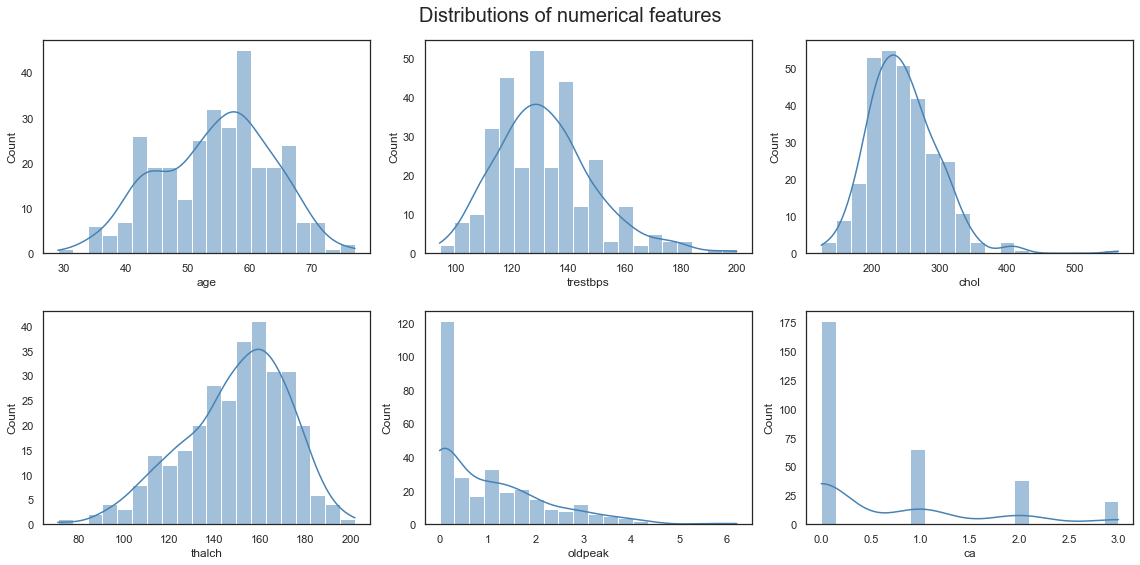

In [108]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for col, ax in zip(num_cols, axes.flat):
    sns.histplot(x=col, data=dataset, bins=20, kde=True, ax=ax, color='steelblue')
fig.suptitle('Distributions of numerical features', fontsize=20)
plt.tight_layout(h_pad=2)

#save_fig("num_cols_distribution_plots")


> for highly skewed features like oldpeak, consider log transformation to give a more normal distribution

For categorical features, let's plot countplot to understand each distribution.

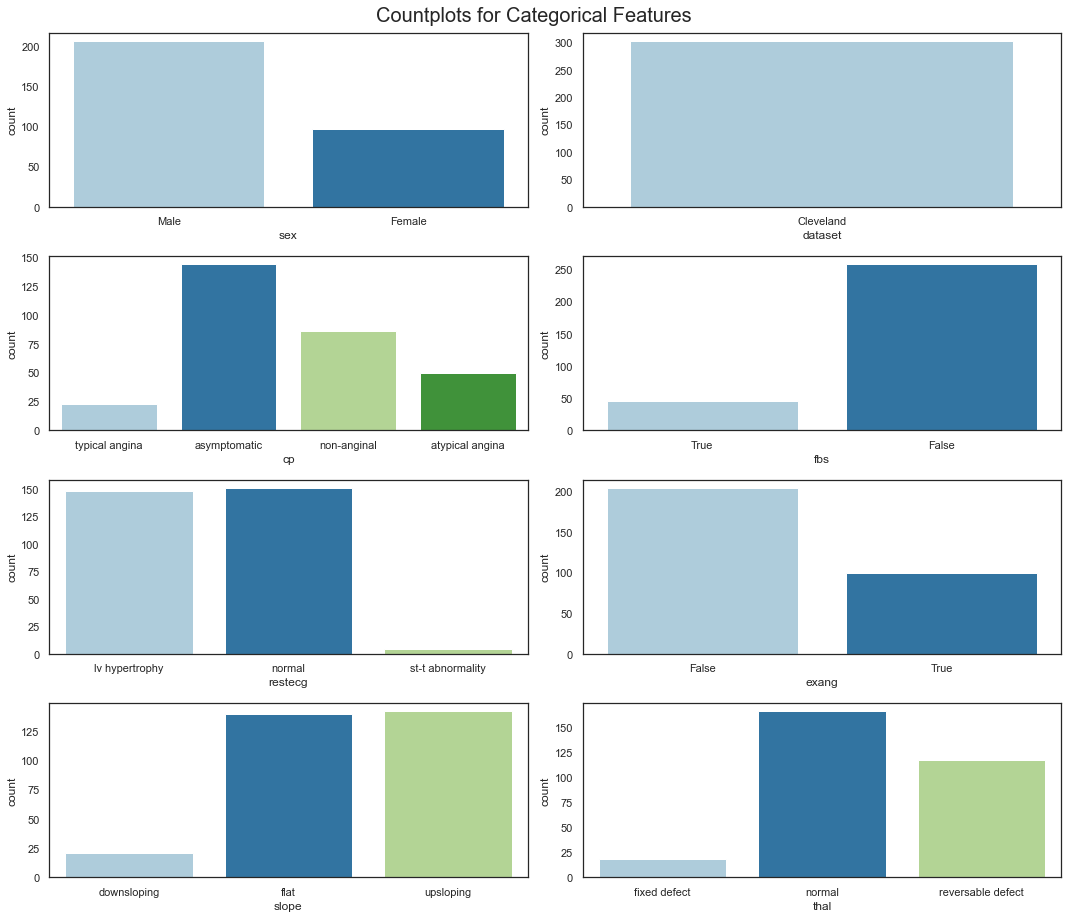

In [109]:
# categorical features
sns.set_palette('Paired')
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 13))
for i, ax in enumerate(axes.flat):
    try:
        sns.countplot(x=dataset[cat_cols[i]], ax=ax)
        if cat_cols[i] == 'job':
            ax.tick_params(axis='x', labelrotation=90)
    except:
        pass
fig.suptitle('Countplots for Categorical Features', fontsize=20)
plt.tight_layout()
#train[num_cols].hist(bins=30, figsize=(15,12))
#save_fig("cat_cols_distribution_plots")

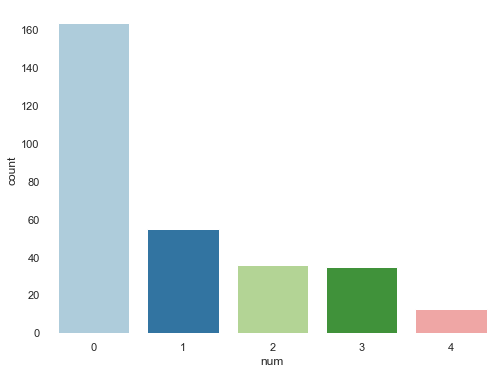

In [110]:
# target variable
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x=dataset['num'], ax=ax)
sns.despine(left=True, bottom=True);

## Correlations<a name="3.2"></a>

### Checking correlation between numerical features

In [111]:
# check correlations between numerical features
corrT = dataset[num_cols + ['num']].corr()
corrT

age  trestbps      chol    thalch   oldpeak        ca       num
age       1.000000  0.284946  0.208950 -0.393806  0.203805  0.362605  0.222853
trestbps  0.284946  1.000000  0.130120 -0.045351  0.189171  0.098773  0.157754
chol      0.208950  0.130120  1.000000 -0.003432  0.046564  0.119000  0.070909
thalch   -0.393806 -0.045351 -0.003432  1.000000 -0.343085 -0.264246 -0.415040
oldpeak   0.203805  0.189171  0.046564 -0.343085  1.000000  0.295832  0.504092
ca        0.362605  0.098773  0.119000 -0.264246  0.295832  1.000000  0.518909
num       0.222853  0.157754  0.070909 -0.415040  0.504092  0.518909  1.000000

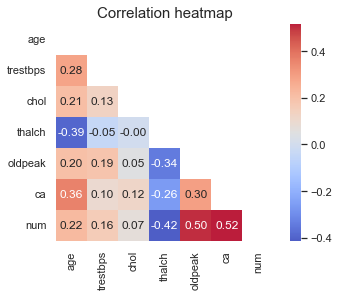

In [112]:
# heatmap of correlation
mask = np.zeros_like(corrT, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrT, annot=True, fmt = '.2f',square=True, cmap='coolwarm', mask=mask, alpha=0.9)
plt.title('Correlation heatmap', fontsize=15);

- **ca** , **oldpeak** and target **num** are most positively correlated
- **ca** and **oldpeak** and **age** are most positively correlated with each other
- **thalch** (maximum heart rate) is negatively correlated with all other factors, no correlation with **cholesterol**

There are multicollinearity of factors here, that might contribute to heart disease and are correlated with each other, this suggest the use of PCA in later part to obtain the principal components

### checking each numerical feature

In [113]:
pd.pivot_table(dataset, index='num', values=num_cols)

age        ca        chol   oldpeak      thalch    trestbps
num                                                                   
0    52.585366  0.273292  242.640244  0.586585  158.378049  129.250000
1    55.381818  0.740741  249.109091  1.005455  145.927273  133.254545
2    58.027778  1.222222  259.277778  1.780556  135.583333  134.194444
3    56.000000  1.457143  246.457143  1.962857  132.057143  135.457143
4    59.692308  1.692308  253.384615  2.361538  140.615385  138.769231

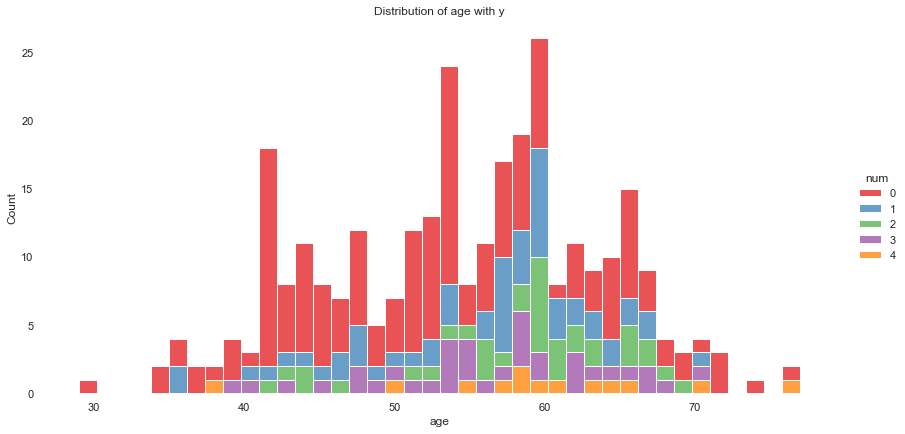

In [114]:
sns.displot(data=dataset, kind='hist', x='age', hue='num', bins=40,
            multiple='stack', height=6, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of age with y');

In [115]:
# try discretize age into groups
min_age = dataset.age.min()
max_age = dataset.age.max()
dataset['age_group'] = pd.cut(dataset.age, bins=[min_age-1, 40, 45, 50, 55, 60, 65, 70, max_age+1])

# check out each age group's size and proportion of subscribing (y=1)
age_group = dataset.pivot_table(index='age_group', values='num', aggfunc=[np.size, np.mean]).reset_index()
age_group.columns = ['age_group', 'size', 'chance/class of heartdisease']
age_group

age_group  size  chance/class of heartdisease
0  (28, 40]    18                      0.722222
1  (40, 45]    45                      0.400000
2  (45, 50]    31                      0.806452
3  (50, 55]    57                      0.789474
4  (55, 60]    73                      1.191781
5  (60, 65]    46                      1.260870
6  (65, 70]    27                      1.259259
7  (70, 78]     6                      0.666667

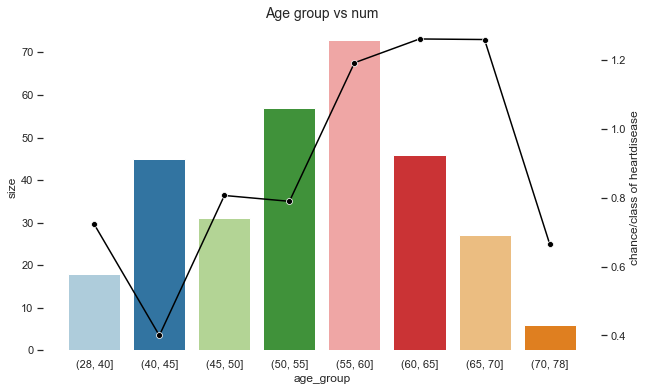

In [116]:
# visualization of age_group
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=age_group, x='age_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=age_group['chance/class of heartdisease'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('Age group vs num', fontsize=14);

**Insights**
- Interestingly, the age groups on the two extreme ends of the spectrum seem to have lower chance/class of heart disease, while the late middle age group have relatively higher chance/class of heart disease. 

- Possible explanation: Younger people is expected to have lower chance of heart disease on the left side of spectrum, while on the right side of spectrum, people who made it past late middle ages are those with relatively healthy heart.

- Moreover, we see that the late middle age group have the largest size.

- This may be because heart disease have higher chance of starting at middle to late middle ages, therefore sampling occurs more at late middle age.

### ca (colored major vessels) vs num

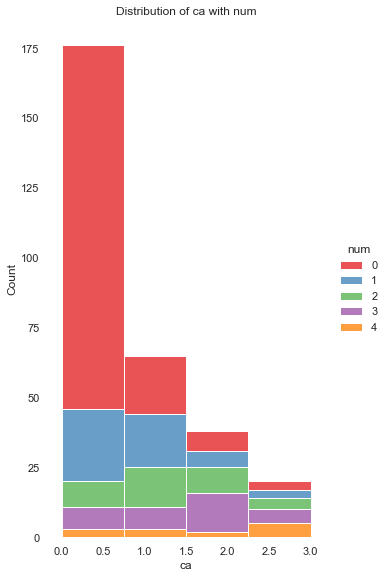

In [117]:
sns.displot(data=dataset, kind='hist', x='ca', hue='num', bins=4,
            multiple='stack', height=8, aspect=0.6, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of ca with num');

The more number of major vessels colored, the more likely to have heart disease and higher class of heart disease

### cholesetrol vs num

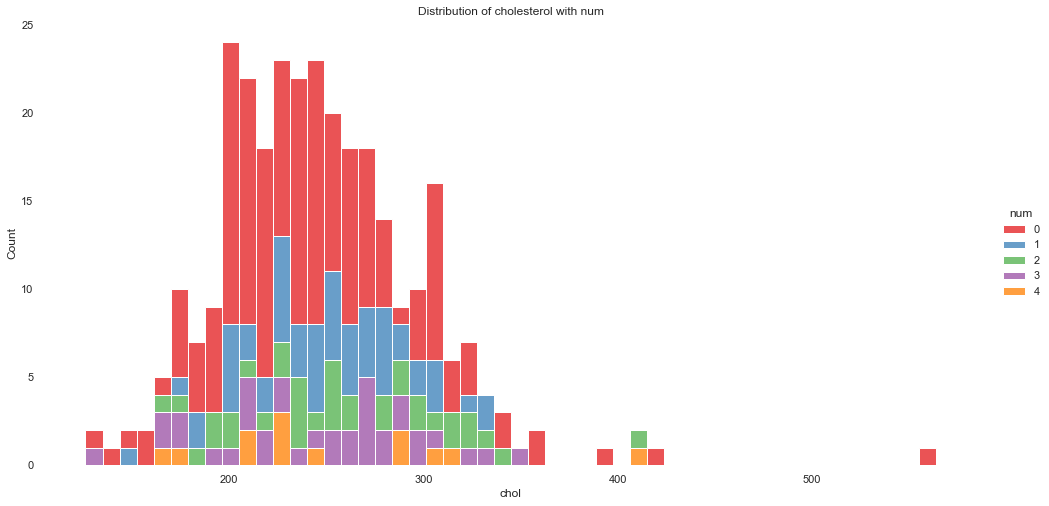

In [118]:
sns.displot(data=dataset, kind='hist', x='chol', hue='num', bins=50,
            multiple='stack', height=7, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of cholesterol with num');

In [119]:
# try discretize cholesterol into groups
min_chol = dataset.chol.min()
max_chol = dataset.chol.max()
dataset['chol_group'] = pd.cut(dataset.chol, bins=[min_chol-1, 150, 200, 250, 300, 350, max_chol+1])

# check out each age group's size and proportion of subscribing (y=1)
chol_group = dataset.pivot_table(index='chol_group', values='num', aggfunc=[np.size, np.mean]).reset_index()
chol_group.columns = ['chol_group', 'size', 'chance/class of heartdisease']
chol_group

chol_group  size  chance/class of heartdisease
0  (125, 150]     5                      0.800000
1  (150, 200]    45                      0.933333
2  (200, 250]   126                      0.761905
3  (250, 300]    83                      1.156627
4  (300, 350]    36                      1.027778
5  (350, 565]     8                      1.125000

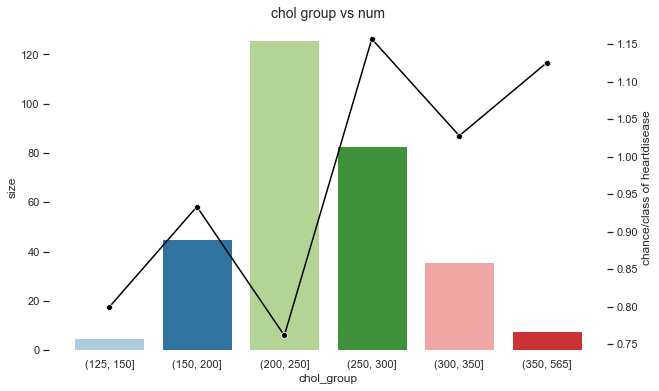

In [120]:
# visualization of chol_group
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=chol_group, x='chol_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=chol_group['chance/class of heartdisease'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('chol group vs num', fontsize=14);

The higher the cholesterol, the more chance and higher class of heart disease

### thalch vs num

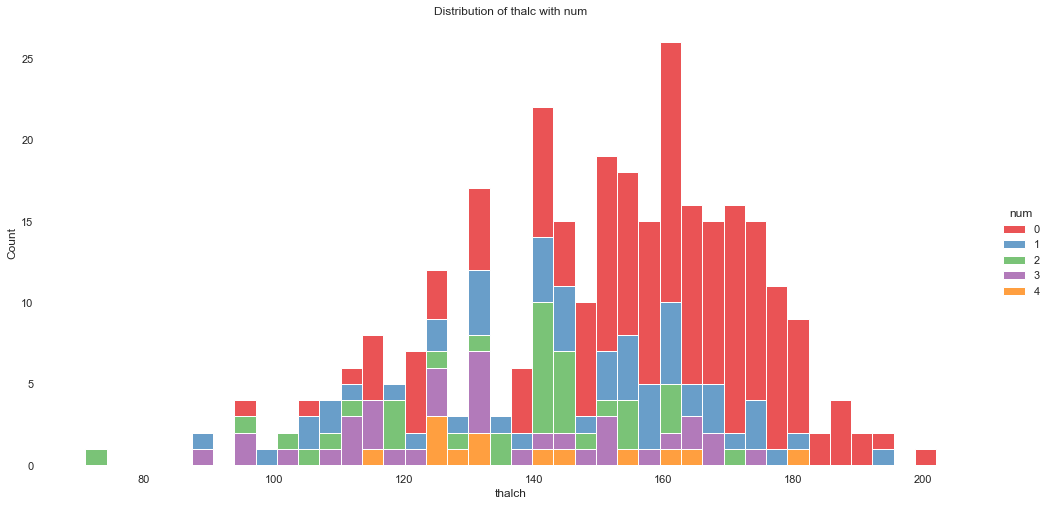

In [121]:
sns.displot(data=dataset, kind='hist', x='thalch', hue='num', bins=40,
            multiple='stack', height=7, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of thalc with num');

In [122]:
# try discretize thalch into groups
min_thalch = dataset.thalch.min()
max_thalch = dataset.thalch.max()
dataset['thalch_group'] = pd.cut(dataset.thalch, bins=[min_thalch-1, 100, 120, 140, 160, 180, max_thalch+1])

# check out each age group's size and proportion of subscribing (y=1)
thalch_group = dataset.pivot_table(index='thalch_group', values='num', aggfunc=[np.size, np.mean]).reset_index()
thalch_group.columns = ['thalch_group', 'size', 'chance/class of heartdisease']
thalch_group

thalch_group  size  chance/class of heartdisease
0    (70, 100]     8                      1.875000
1   (100, 120]    29                      1.758621
2   (120, 140]    54                      1.574074
3   (140, 160]   102                      0.833333
4   (160, 180]    92                      0.456522
5   (180, 203]    18                      0.333333

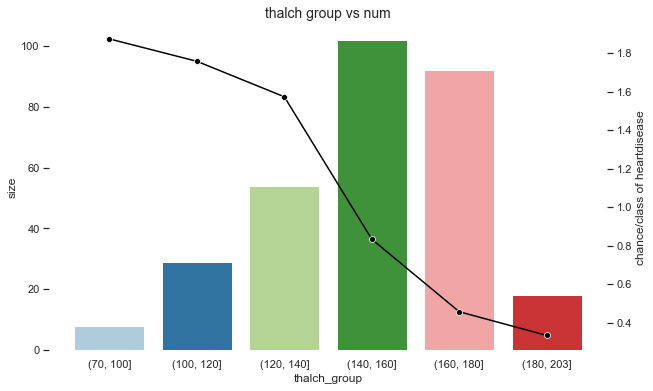

In [123]:
# visualization of thalch group
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=thalch_group, x='thalch_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=thalch_group['chance/class of heartdisease'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('thalch group vs num', fontsize=14);

Thalch (maximum heart rate achieved) is strongly negatively correlated to chance/class of heartdisease

### oldpeak vs num

In [124]:
dataset['oldpeak_log'] = dataset['oldpeak'].apply(lambda x: np.log1p(x))

In [125]:
sns.displot(data=dataset, kind='hist', x='oldpeak', hue='num', bins=40,
            multiple='stack', height=7, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of oldpeak with num');

In [126]:
#its a bit hard to visualize, lets try discretization again
min_oldpeak = dataset.oldpeak.min()
max_oldpeak = dataset.oldpeak.max()
dataset['oldpeak_group'] = pd.cut(dataset.oldpeak, bins=[min_oldpeak-1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, max_oldpeak+1])

# check out each age group's size and proportion of subscribing (y=1)
oldpeak_group = dataset.pivot_table(index='oldpeak_group', values='num', aggfunc=[np.size, np.mean]).reset_index()
oldpeak_group.columns = ['oldpeak_group', 'size', 'chance/class of heartdisease']
oldpeak_group

oldpeak_group  size  chance/class of heartdisease
0   (-1.0, 0.5]   135                      0.414815
1    (0.5, 1.0]    45                      1.022222
2    (1.0, 1.5]    38                      0.894737
3    (1.5, 2.0]    35                      1.200000
4    (2.0, 2.5]    12                      1.666667
5    (2.5, 3.0]    18                      2.055556
6    (3.0, 3.5]     7                      1.857143
7    (3.5, 4.0]     8                      2.875000
8    (4.0, 7.2]     5                      2.600000

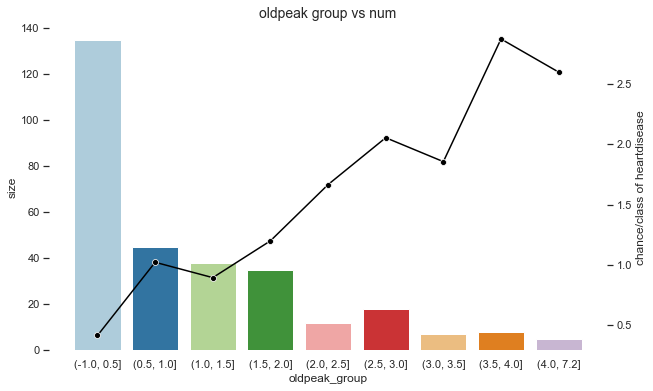

In [127]:
# visualization of oldpeak group
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=oldpeak_group, x='oldpeak_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=oldpeak_group['chance/class of heartdisease'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('oldpeak group vs num', fontsize=14);

The higher the oldpeak, the higher the chance/class of heart disease

Also, size decreases as oldpeak increases.

### trestbps vs num

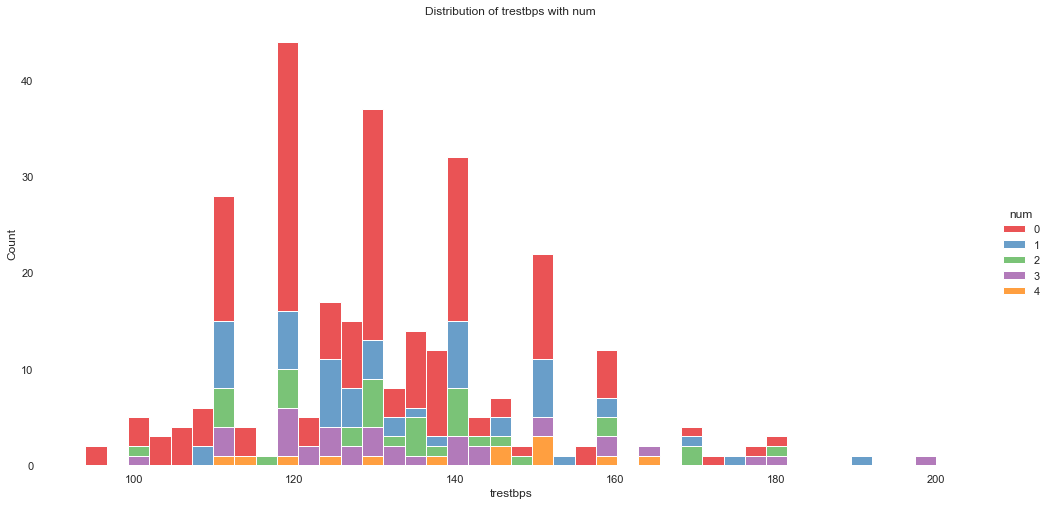

In [128]:
sns.displot(data=dataset, kind='hist', x='trestbps', hue='num', bins=40,
            multiple='stack', height=7, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of trestbps with num');

In [129]:
#its a bit hard to visualize, lets try discretization again
min_trestbps = dataset.trestbps.min()
max_trestbps = dataset.trestbps.max()
dataset['trestbps_group'] = pd.cut(dataset.trestbps, bins=[min_trestbps-1, 110, 120, 130, 140, 150, 160, 170, max_trestbps+1])

# check out each age group's size and proportion of subscribing (y=1)
trestbps_group = dataset.pivot_table(index='trestbps_group', values='num', aggfunc=[np.size, np.mean]).reset_index()
trestbps_group.columns = ['trestbps_group', 'size', 'chance/class of heartdisease']
trestbps_group

trestbps_group  size  chance/class of heartdisease
0      (93, 110]    39                      0.666667
1     (110, 120]    58                      0.827586
2     (120, 130]    74                      0.905405
3     (130, 140]    66                      0.833333
4     (140, 150]    31                      1.387097
5     (150, 160]    20                      1.000000
6     (160, 170]     6                      2.000000
7     (170, 201]     9                      1.444444

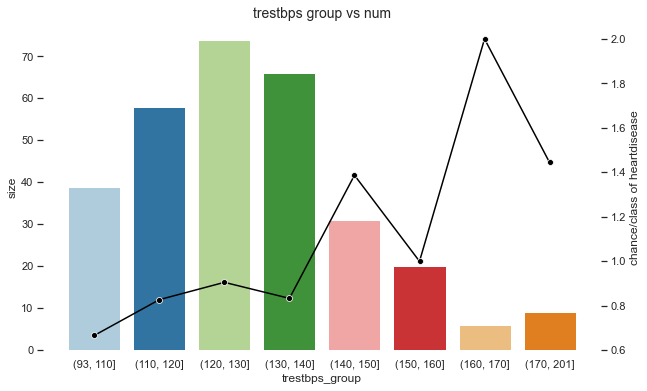

In [130]:
# visualization of trestbps group
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=trestbps_group, x='trestbps_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=trestbps_group['chance/class of heartdisease'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('trestbps group vs num', fontsize=14);

The higher the trestbps, the higher the chance/class of heartdisease

### How does each categorical feature correlate with our target? <a name="3.4"></a>

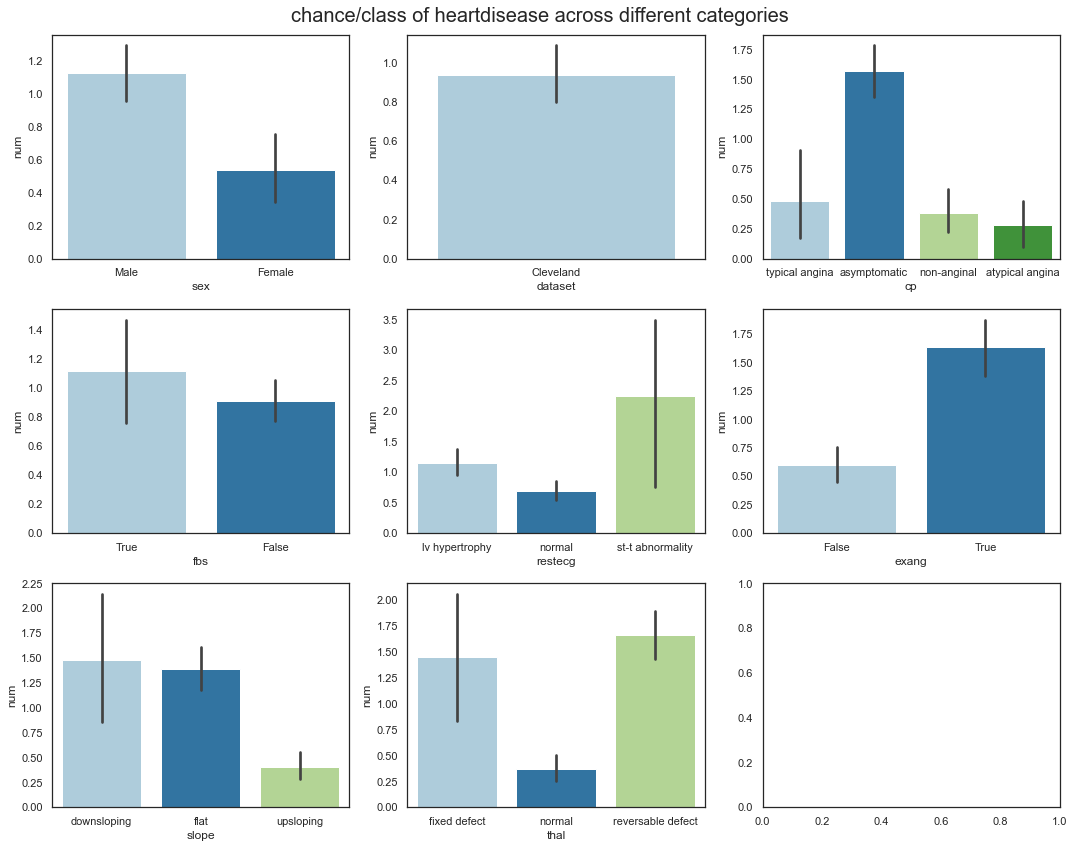

In [131]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
try:
    for i, ax in enumerate(axes.flat):
        sns.barplot(data=dataset, x=cat_cols[i], y='num', ax=ax, palette='Paired')
except:
    pass

plt.suptitle('chance/class of heartdisease across different categories', fontsize=20)
plt.tight_layout()

### Experimenting attribute combinations <a name='3.5'></a>

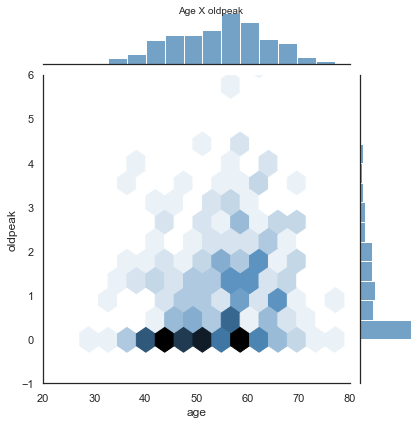

In [132]:
# age x oldpeak
sns.jointplot(data=dataset, x='age', y='oldpeak', 
              kind='hex', height=6, xlim=(20, 80), ylim=(-1, 6), color='steelblue')
plt.suptitle('Age X oldpeak', fontsize=10);

- low oldpeak seems to evenly spread across middle ages, higher old peak seems to occur more at late middle age
- this matches our previously plotted correlation heatmap where oldpeak and age have a positive correlation of 0.2

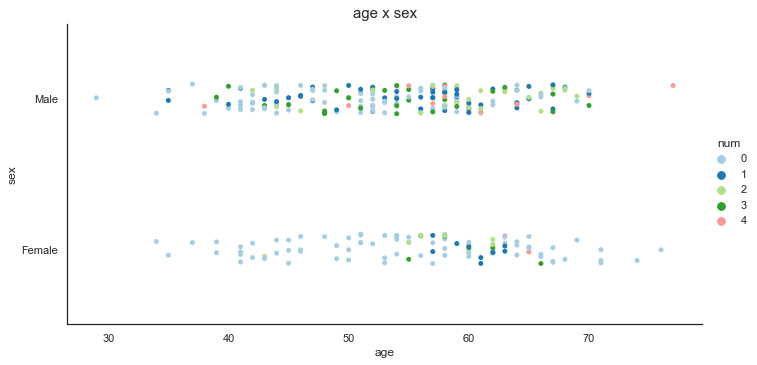

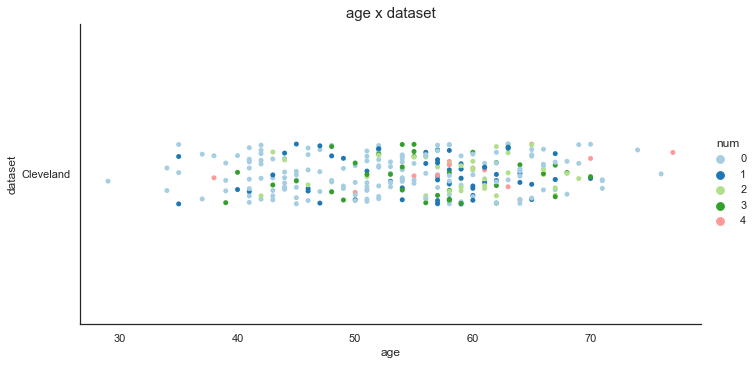

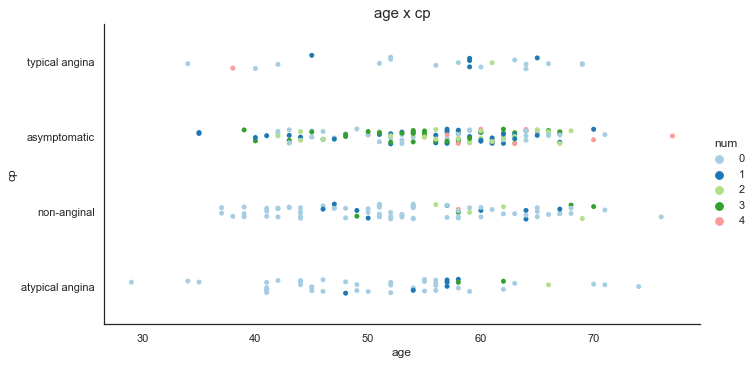

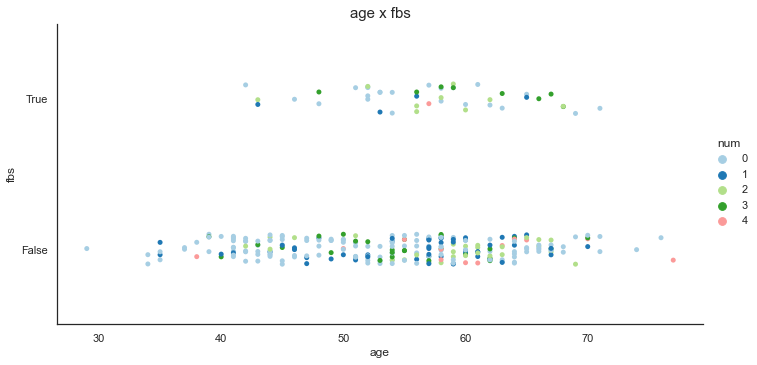

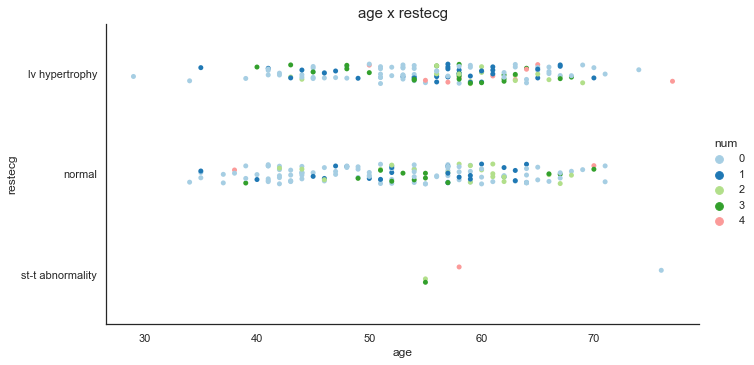

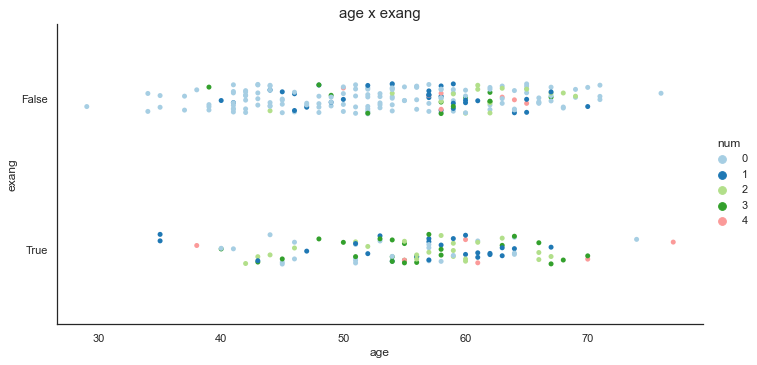

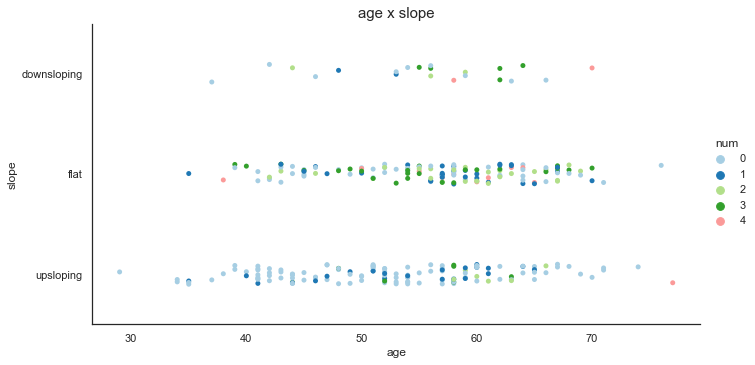

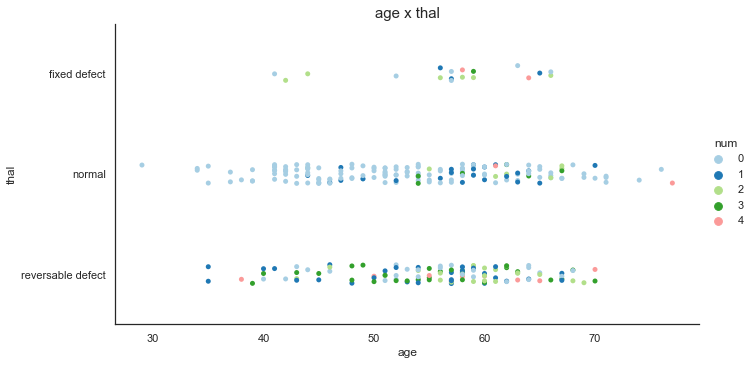

In [133]:
# age x cat_cols
for col in cat_cols:
    sns.catplot(data=dataset, x='age', y=col, hue='num', kind='strip', aspect=2, jitter=True)
    plt.title('age x {}'.format(col), fontsize=15);

**Observations**
- fixed defect and downslope (peak ST excercise) occur more at higher age

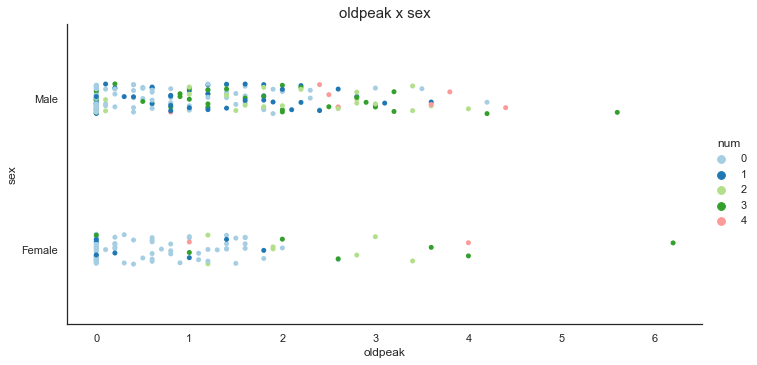

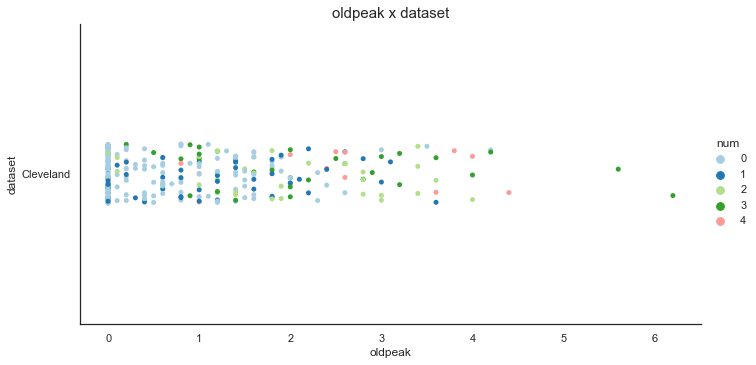

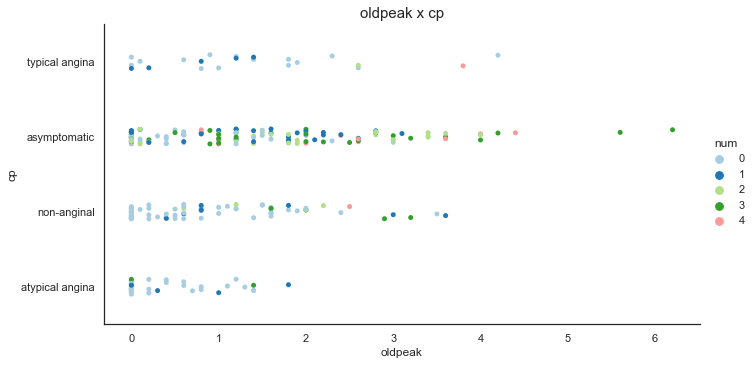

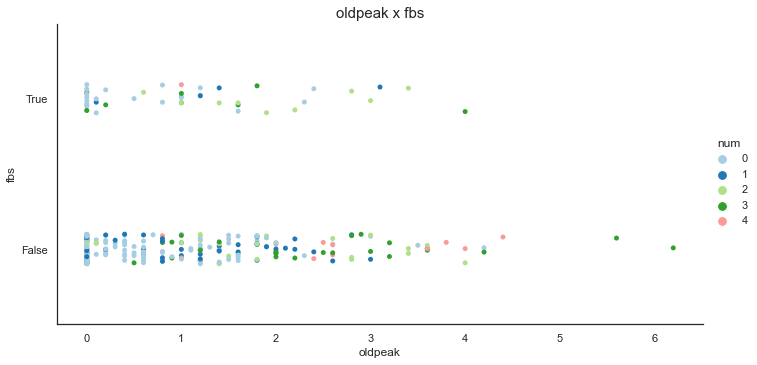

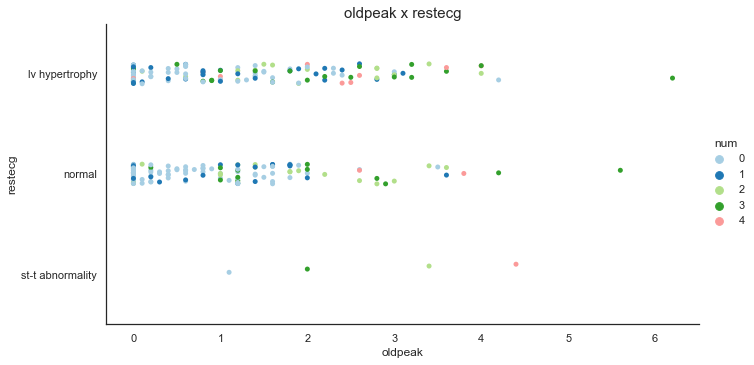

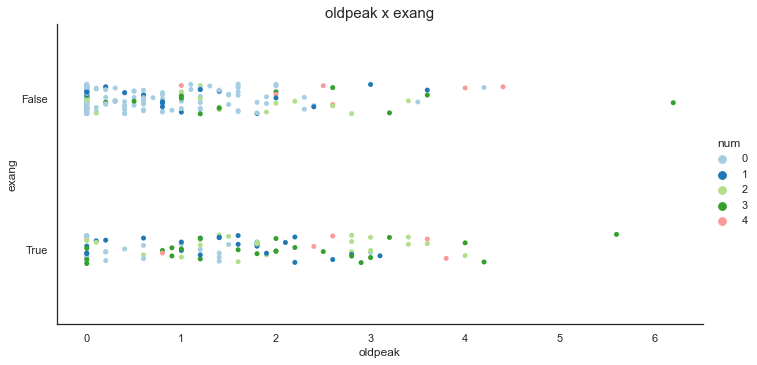

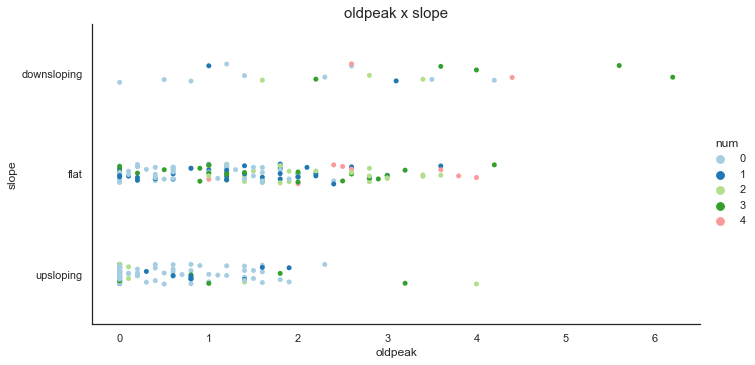

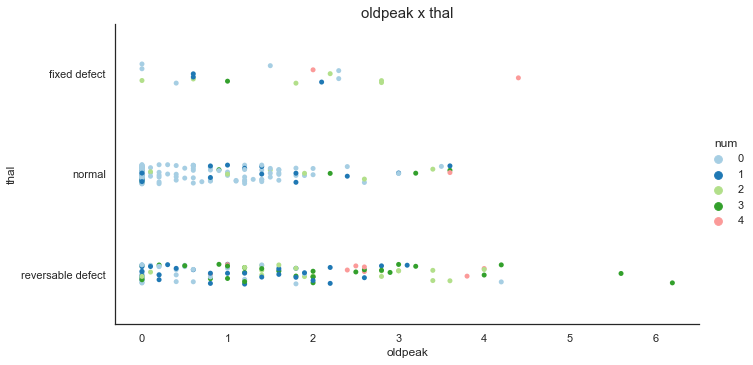

In [134]:
# oldpeak x cat_cols
for col in cat_cols:
    sns.catplot(data=dataset, x='oldpeak', y=col, hue='num', kind='strip', aspect=2, jitter=True)
    plt.title('oldpeak x {}'.format(col), fontsize=15);

**Observations**
- male have higher chance of high oldpeak and higher class of heart disease than females

- higher oldpeak are more likely to occur at downslope (peak ST excercise)

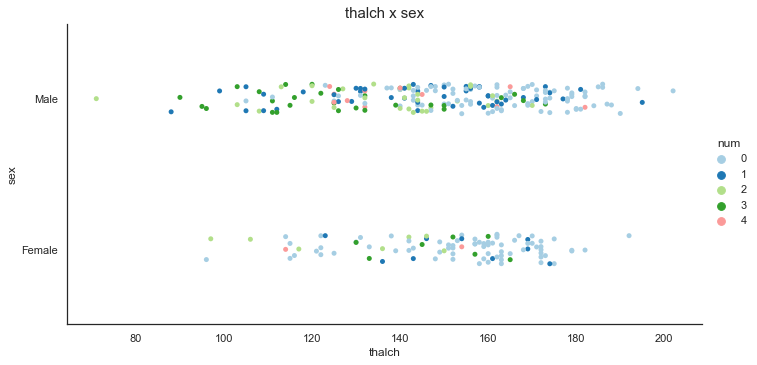

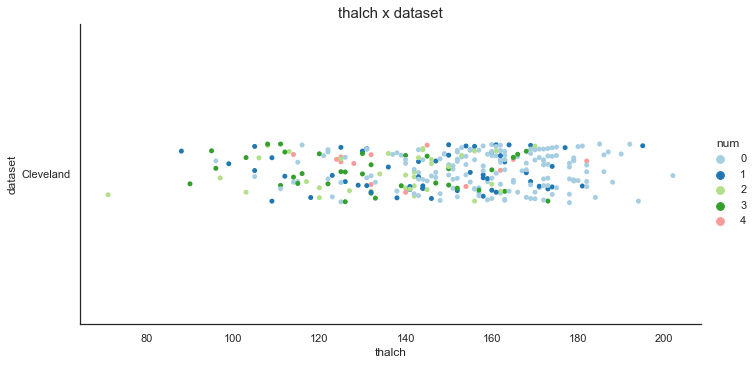

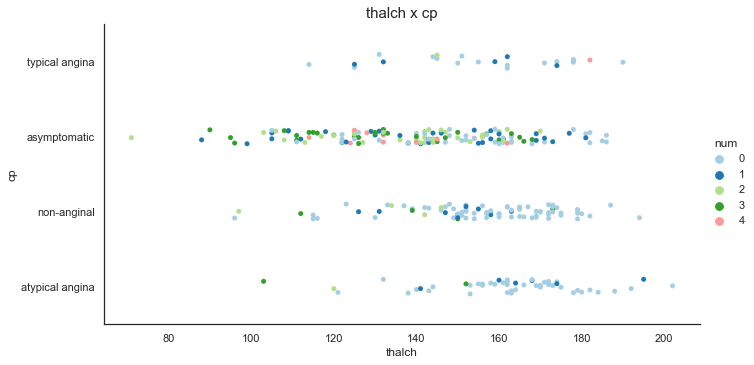

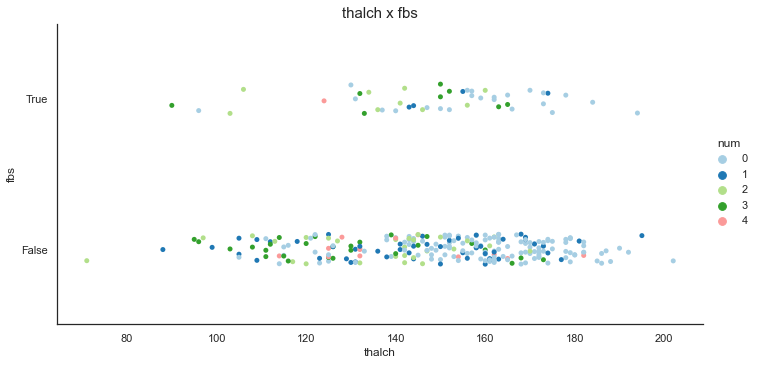

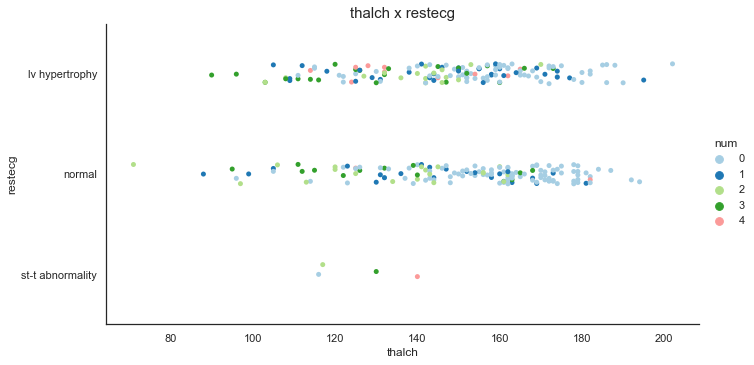

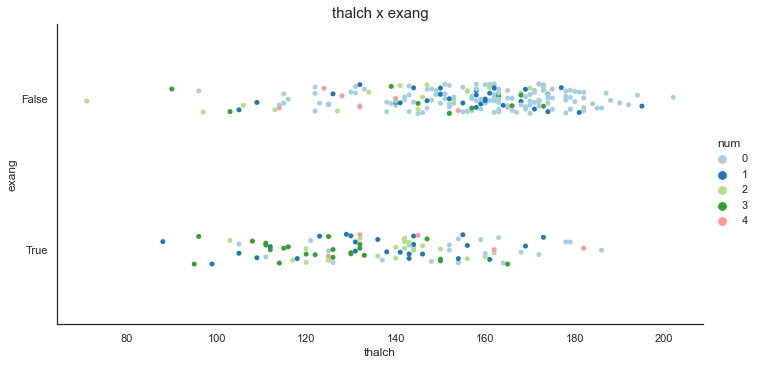

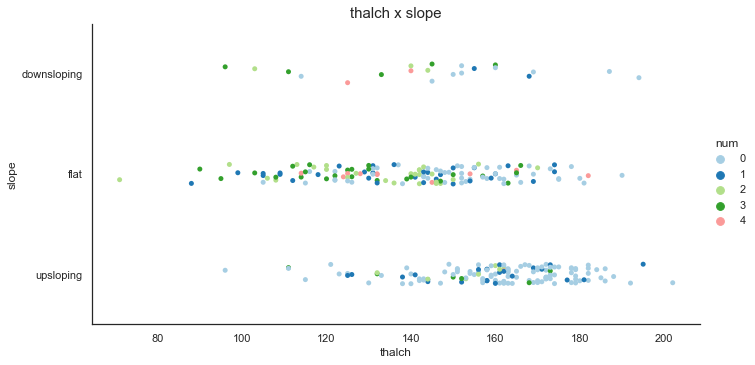

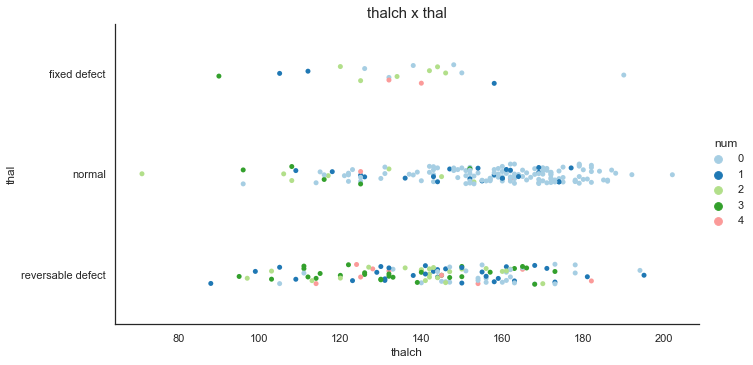

In [135]:
# thalch x cat_cols
for col in cat_cols:
    sns.catplot(data=dataset, x='thalch', y=col, hue='num', kind='strip', aspect=2, jitter=True)
    plt.title('thalch x {}'.format(col), fontsize=15);

**Observations**
- male have higher chance of low thalch and higher class of heart disease than females
- True exang is more likely to occur at lower thalch

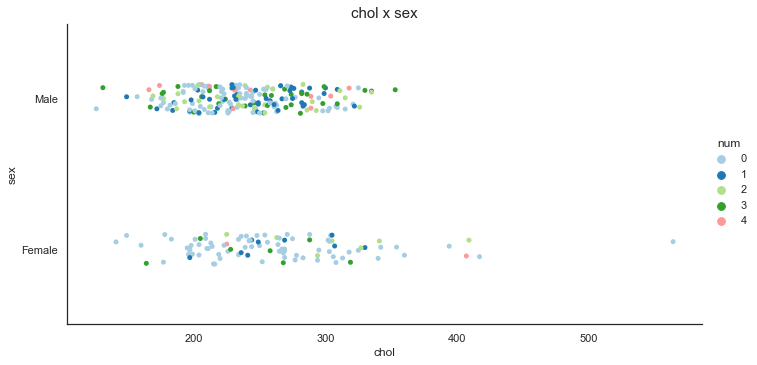

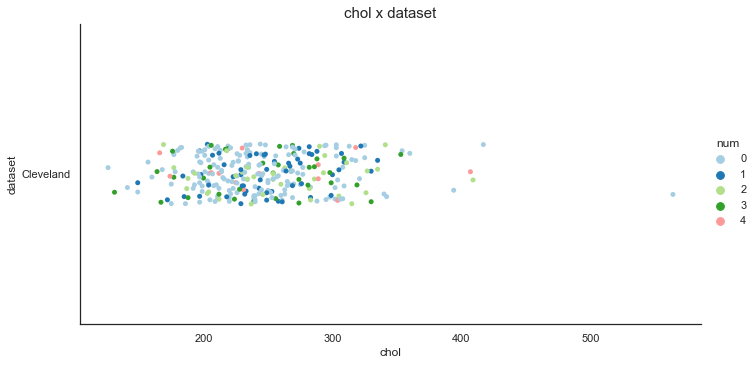

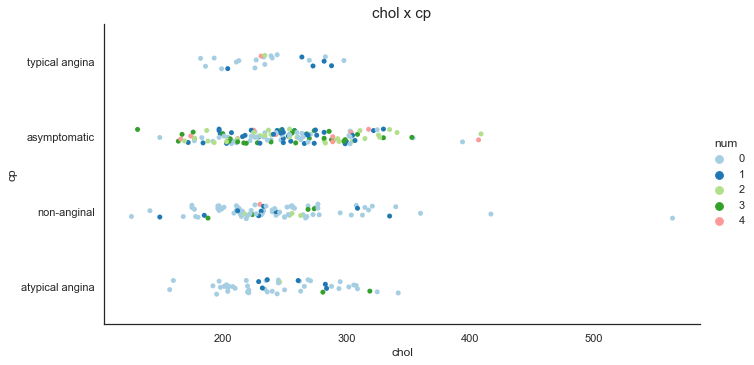

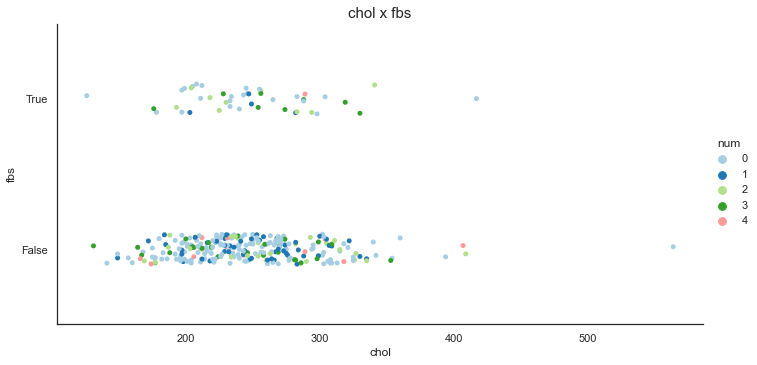

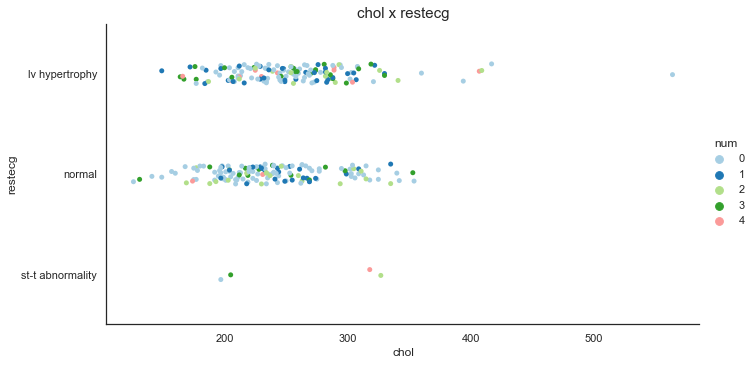

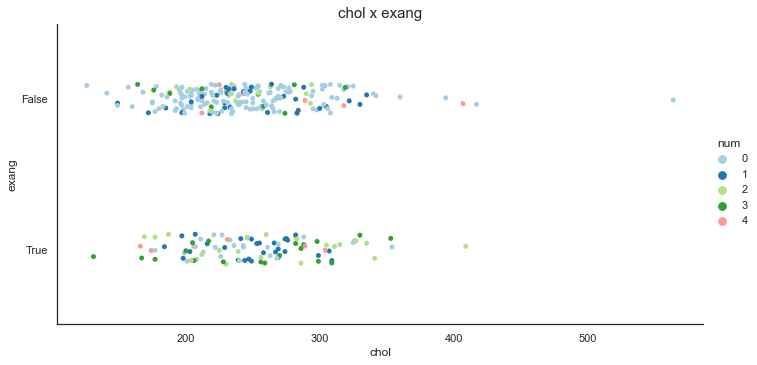

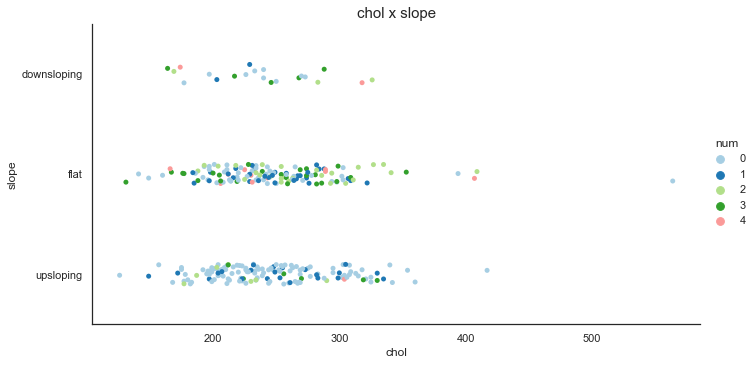

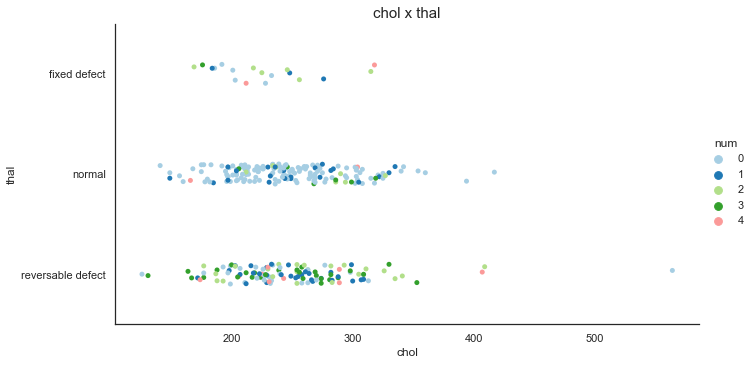

In [136]:
# chol x cat_cols
for col in cat_cols:
    sns.catplot(data=dataset, x='chol', y=col, hue='num', kind='strip', aspect=2, jitter=True)
    plt.title('chol x {}'.format(col), fontsize=15);

**Observations**
- True exang is slightly more likely to occur at hgiher cholesterol

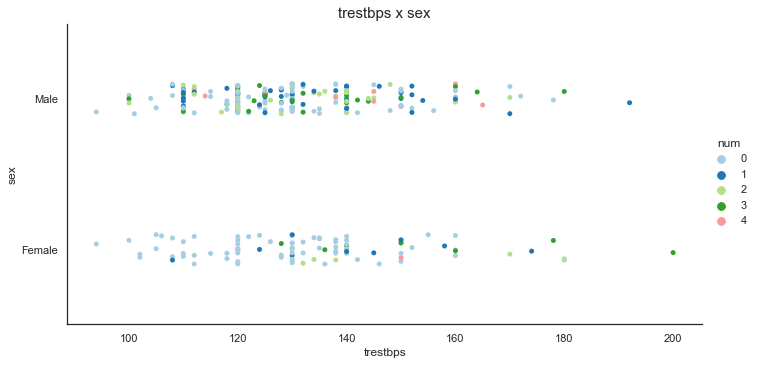

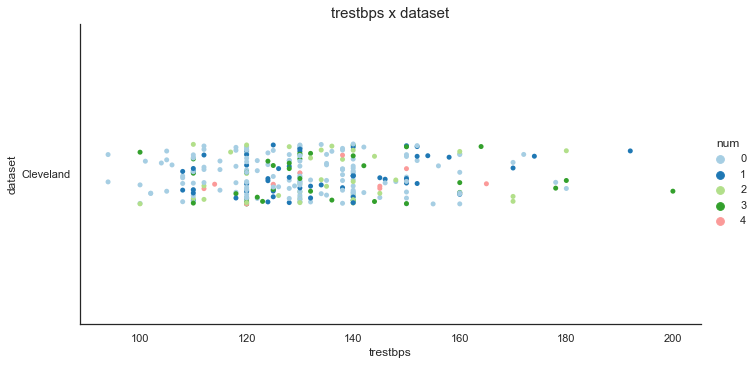

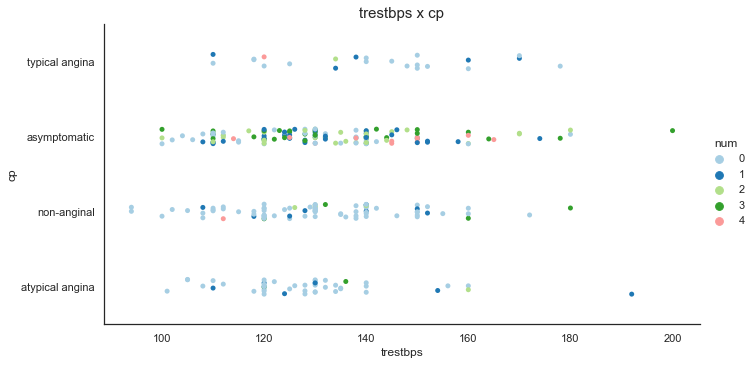

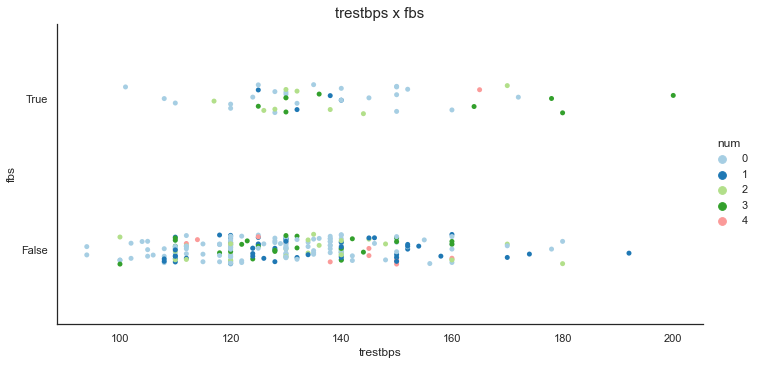

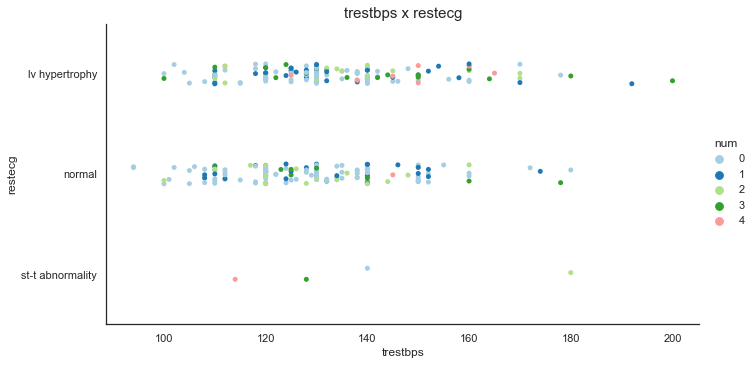

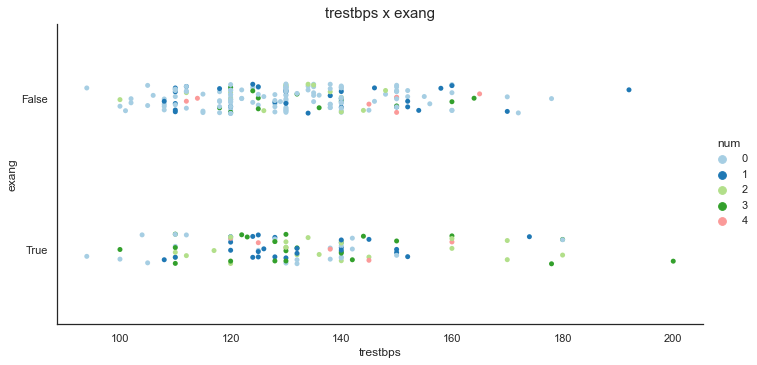

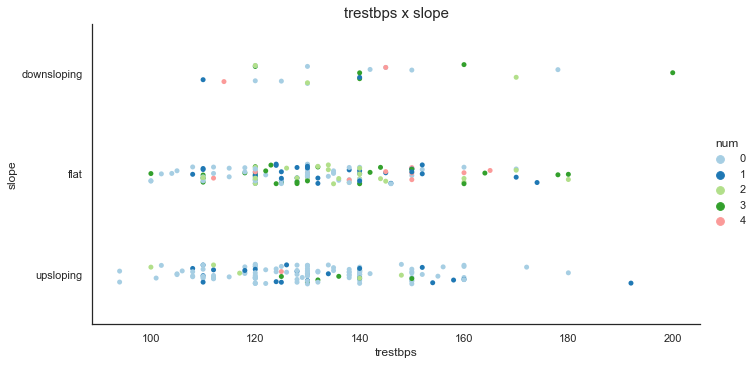

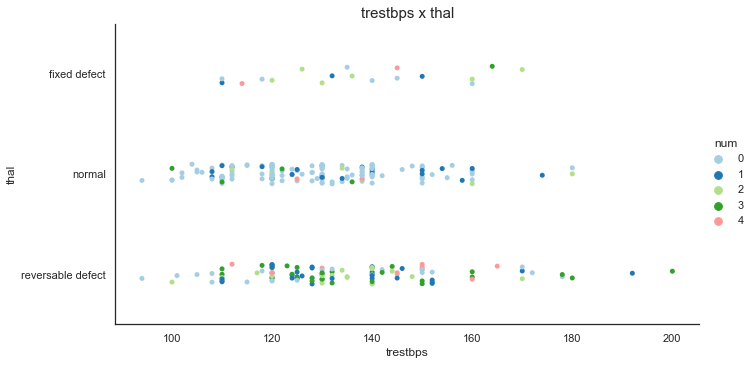

In [137]:
# trestbps x cat_cols
for col in cat_cols:
    sns.catplot(data=dataset, x='trestbps', y=col, hue='num', kind='strip', aspect=2, jitter=True)
    plt.title('trestbps x {}'.format(col), fontsize=15);

**Observations**
- typical angina is more likely to occur at higher trestbps

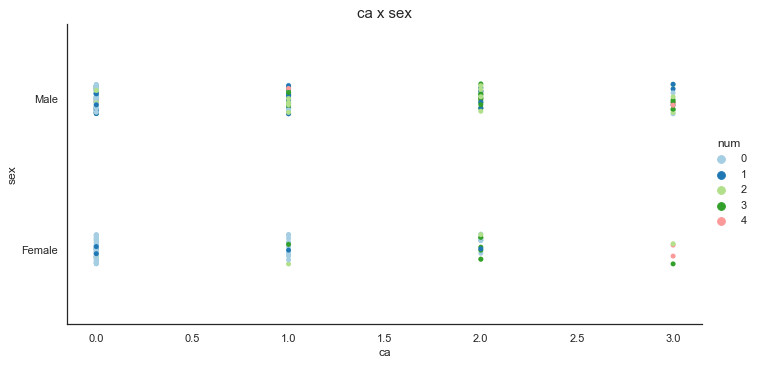

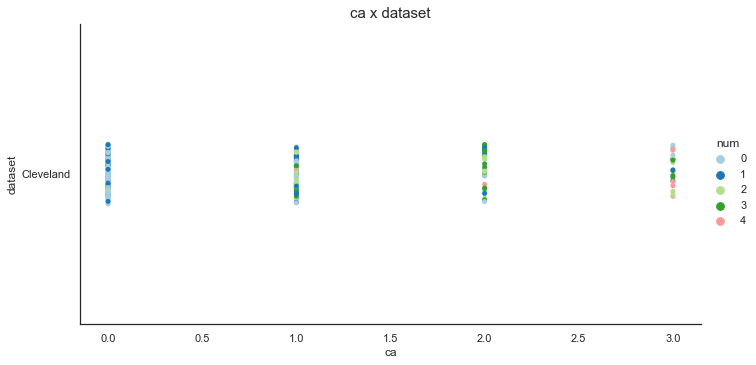

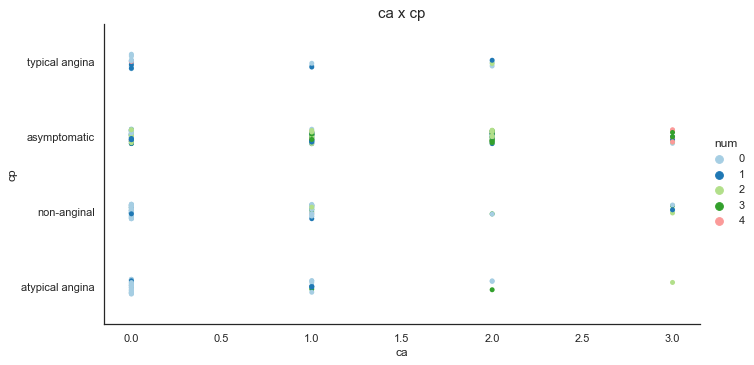

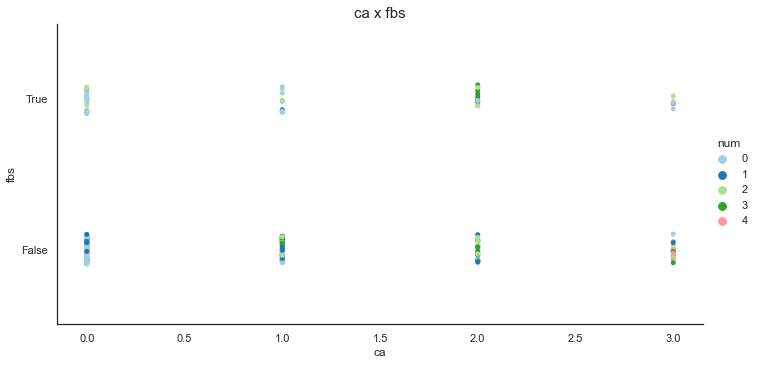

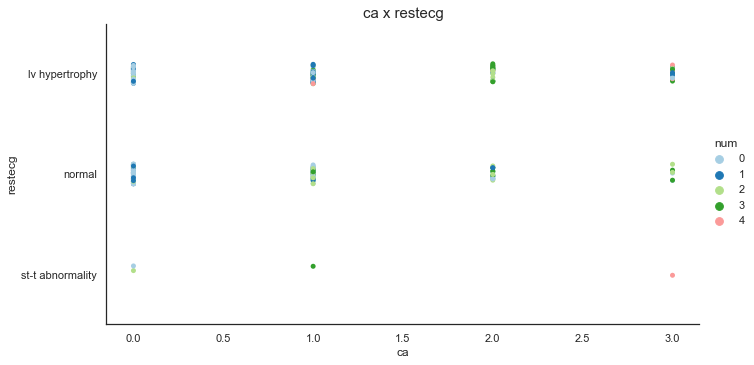

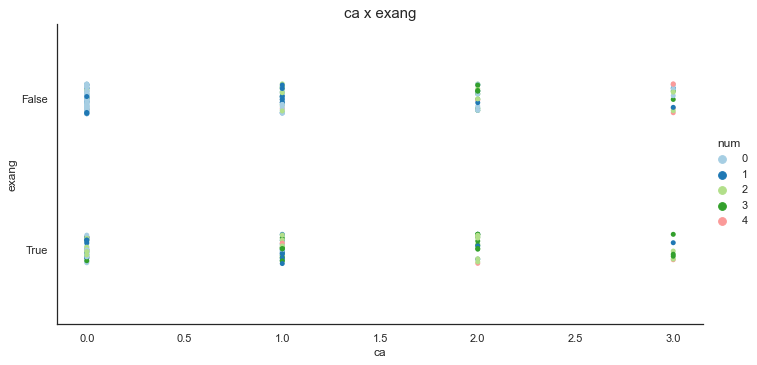

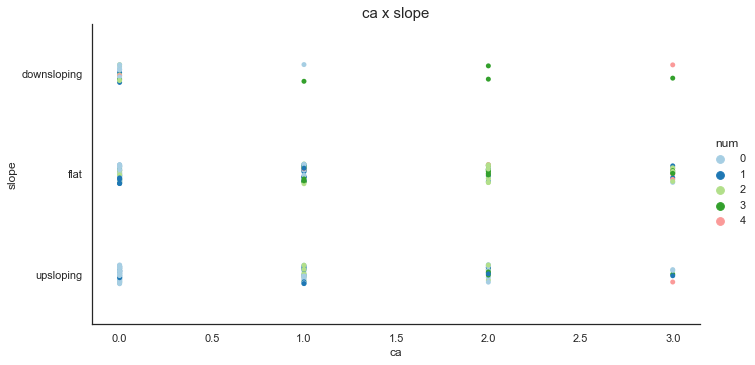

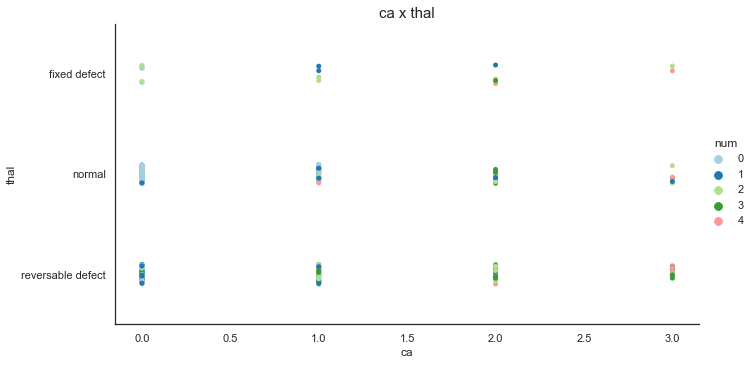

In [138]:
# ca x cat_cols
for col in cat_cols:
    sns.catplot(data=dataset, x='ca', y=col, hue='num', kind='strip', aspect=2, jitter=True)
    plt.title('ca x {}'.format(col), fontsize=15);

<a name="4"></a>
# 4 - Preprocessing

In [139]:
# preprocessor and pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [140]:
dataset.head()

age     sex    dataset               cp  trestbps  chol    fbs  \
0   63    Male  Cleveland   typical angina       145   233   True   
1   67    Male  Cleveland     asymptomatic       160   286  False   
2   67    Male  Cleveland     asymptomatic       120   229  False   
3   37    Male  Cleveland      non-anginal       130   250  False   
4   41  Female  Cleveland  atypical angina       130   204  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy     150  False      2.3  downsloping  0.0   
1  lv hypertrophy     108   True      1.5         flat  3.0   
2  lv hypertrophy     129   True      2.6         flat  2.0   
3          normal     187  False      3.5  downsloping  0.0   
4  lv hypertrophy     172  False      1.4    upsloping  0.0   

                thal  num age_group  chol_group thalch_group  oldpeak_log  \
0       fixed defect    0  (60, 65]  (200, 250]   (140, 160]     1.193922   
1             normal    2  (65, 70]  (250, 300]   (100, 120]     0.916291   
2  reversable defect    1  (65, 70]  (200, 250]   (120, 140]     1.280934   
3             normal    0  (28, 40]  (200, 250]   (180, 203]     1.504077   
4             normal    0  (40, 45]  (200, 250]   (160, 180]     0.875469   

  oldpeak_group trestbps_group  
0    (2.0, 2.5]     (140, 150]  
1    (1.0, 1.5]     (150, 160]  
2    (2.5, 3.0]     (110, 120]  
3    (3.0, 3.5]     (120, 130]  
4    (1.0, 1.5]     (120, 130]

In [141]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             303 non-null    int64   
 1   sex             303 non-null    object  
 2   dataset         303 non-null    object  
 3   cp              303 non-null    object  
 4   trestbps        303 non-null    int64   
 5   chol            303 non-null    int64   
 6   fbs             303 non-null    object  
 7   restecg         303 non-null    object  
 8   thalch          303 non-null    int64   
 9   exang           303 non-null    object  
 10  oldpeak         303 non-null    float64 
 11  slope           303 non-null    object  
 12  ca              299 non-null    float64 
 13  thal            301 non-null    object  
 14  num             303 non-null    int64   
 15  age_group       303 non-null    category
 16  chol_group      303 non-null    category
 17  thalch_group    

###   fixing null values

There are null values in `ca` and `thal` attributes, lets see if we can imput them.

In [142]:
pd.set_option('display.max_columns', 500)
dataset[dataset['ca'].isna()]

age   sex    dataset               cp  trestbps  chol    fbs  \
166   52  Male  Cleveland      non-anginal       138   223  False   
192   43  Male  Cleveland     asymptomatic       132   247   True   
287   58  Male  Cleveland  atypical angina       125   220  False   
302   38  Male  Cleveland      non-anginal       138   175  False   

            restecg  thalch  exang  oldpeak      slope  ca               thal  \
166          normal     169  False      0.0  upsloping NaN             normal   
192  lv hypertrophy     143   True      0.1       flat NaN  reversable defect   
287          normal     144  False      0.4       flat NaN  reversable defect   
302          normal     173  False      0.0  upsloping NaN             normal   

     num age_group  chol_group thalch_group  oldpeak_log oldpeak_group  \
166    0  (50, 55]  (200, 250]   (160, 180]     0.000000   (-1.0, 0.5]   
192    1  (40, 45]  (200, 250]   (140, 160]     0.095310   (-1.0, 0.5]   
287    0  (55, 60]  (200, 250]   (140, 160]     0.336472   (-1.0, 0.5]   
302    0  (28, 40]  (150, 200]   (160, 180]     0.000000   (-1.0, 0.5]   

    trestbps_group  
166     (130, 140]  
192     (130, 140]  
287     (120, 130]  
302     (130, 140]

Checking the other attributes for the null ca rows, we observe that num show either 0 or 1. From the  ca (colored major vessels) vs num plot, we can see that majority of ca values are 0, for num value of 0, hence we can imput row 166, 287 and 302 with ca of 0.

However for row 192, num = 1 is not confident enough to tell us our best guess. So based on correlation table, age vs ca show the highest correlation to age, hence we look at age to determine our best guess for ca.

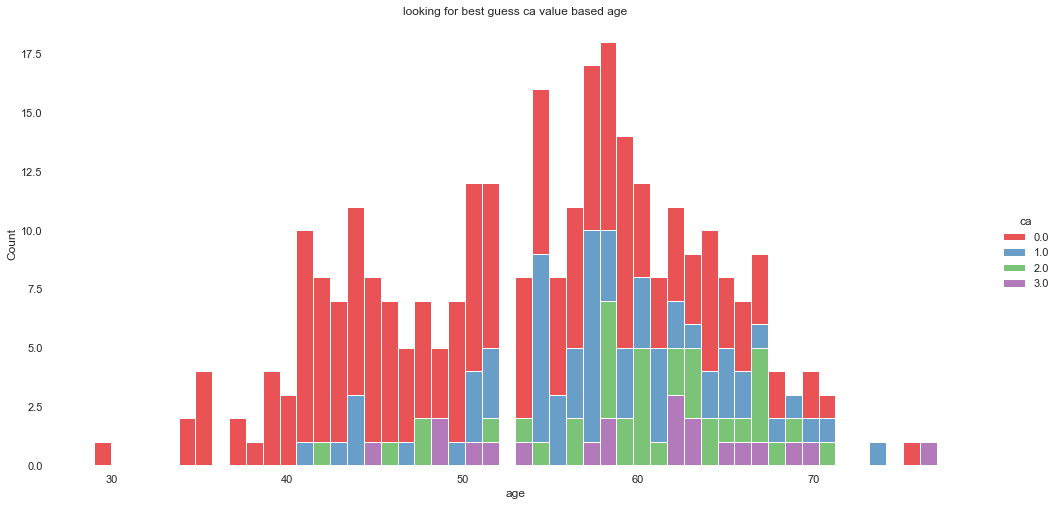

In [143]:
# visualization of age vs ca
sns.displot(data=dataset, kind='hist', x='age', hue='ca', bins=50,
            multiple='stack', height=7, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('looking for best guess ca value based age');

based on the above visualization, age 43 will most likely give us ca value of 0. Hence, we will impute row 192 ca with 0 too.

In [144]:
dataset.loc[166,'ca'] = 0.0
dataset.loc[192,'ca'] = 0.0
dataset.loc[287,'ca'] = 0.0
dataset.loc[302,'ca'] = 0.0

Next, we mose to fixing `thal`

In [145]:
dataset[dataset['thal'].isna()]

age     sex    dataset            cp  trestbps  chol    fbs  \
87    53  Female  Cleveland   non-anginal       128   216  False   
266   52    Male  Cleveland  asymptomatic       128   204   True   

            restecg  thalch  exang  oldpeak      slope   ca thal  num  \
87   lv hypertrophy     115  False      0.0  upsloping  0.0  NaN    0   
266          normal     156   True      1.0       flat  0.0  NaN    2   

    age_group  chol_group thalch_group  oldpeak_log oldpeak_group  \
87   (50, 55]  (200, 250]   (100, 120]     0.000000   (-1.0, 0.5]   
266  (50, 55]  (200, 250]   (140, 160]     0.693147    (0.5, 1.0]   

    trestbps_group  
87      (120, 130]  
266     (120, 130]

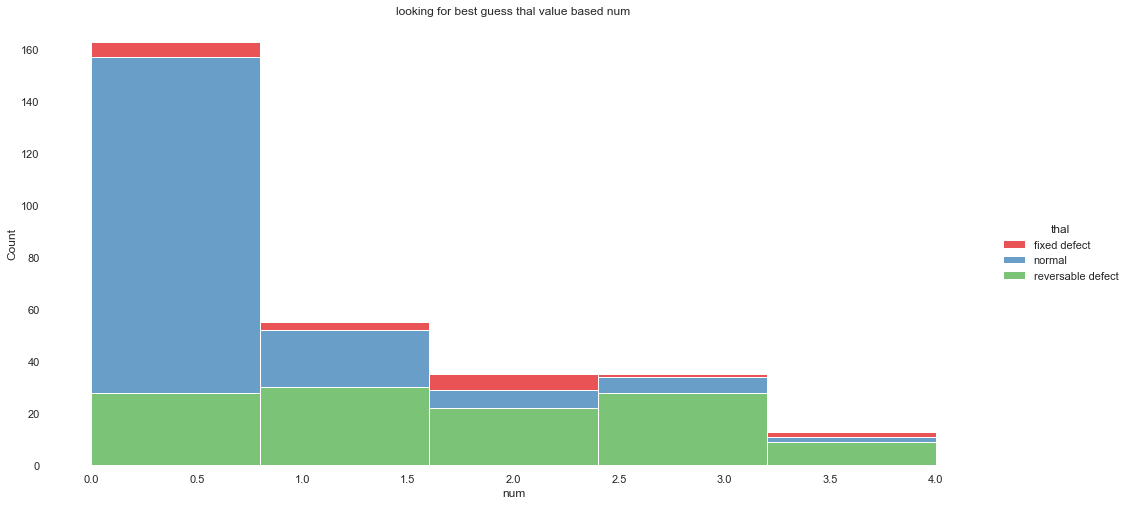

In [146]:
# visualization of thal vs num
sns.displot(data=dataset, kind='hist', x='num', hue='thal', bins=5,
            multiple='stack', height=7, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('looking for best guess thal value based num');

from the above plot, 
- row 87 num = 0 gives a best guess of thal = normal
- row 266 num = 2 gives a best guess of thal = reversable defect

In [147]:
dataset.loc[87,'thal'] = 'normal'
dataset.loc[266,'thal'] = 'reversable defect'

In [148]:
#ensure no more null values
dataset[dataset.isna().any(axis=1)]

Empty DataFrame
Columns: [age, sex, dataset, cp, trestbps, chol, fbs, restecg, thalch, exang, oldpeak, slope, ca, thal, num, age_group, chol_group, thalch_group, oldpeak_log, oldpeak_group, trestbps_group]
Index: []

In [149]:
dataset.columns

Index(['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'age_group',
       'chol_group', 'thalch_group', 'oldpeak_log', 'oldpeak_group',
       'trestbps_group'],
      dtype='object')

In [150]:
cat_cols

['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [151]:
num_cols

['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

In [152]:
#dataset['num_Cat'] = dataset['num'].replace({0: 'Not present', 1: 'Class 1', 2: 'Class 2', 3: 'Class 3', 4: 'Class 4'}, inplace=False)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(dataset[num_cols + cat_cols] ,dataset['num'], test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

<a name="5"></a>
# 5 - Modeling - Supervised learning

The goal is to predict the presence and class of heart disease. This is an imbalance multi-class classification problem. The primary metric is `recall` and `precision` of the positive classes, with `F1-score` being a balance of the two. We do not want patients to be under diagnosed, neither do we want them to be over diagnosed, as both of these cases will not allow them to get suitable treatments, hence in this project, we focus on optimizing based on `F1-score`

In [154]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb

# evaluations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

## Baseline models <a name='5.1'></a>

In [155]:
def plotconfusion(model, X_test_prepared, y_test):
    fig, ax = plt.subplots(figsize=(5,4))
    color = 'white'
    matrix = plot_confusion_matrix(model, X_test_prepared, y_test, cmap=plt.cm.Blues, ax = ax)
    matrix.ax_.set_title('Confusion Matrix', color=color)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.show()

### Here just quickly try a few baseline models with default parameters and all features to get a feel

### logistic regression

mean cv macro_f1 score: 0.312
              precision    recall  f1-score   support

           0       0.84      0.72      0.78        29
           1       0.08      0.08      0.08        12
           2       0.00      0.00      0.00         9
           3       0.24      0.57      0.33         7
           4       0.33      0.25      0.29         4

    accuracy                           0.44        61
   macro avg       0.30      0.33      0.30        61
weighted avg       0.46      0.44      0.44        61



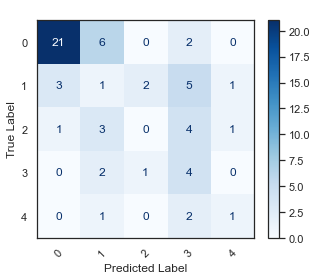

In [156]:
lr = LogisticRegression(max_iter=500, class_weight='balanced')
lr_scores = cross_val_score(lr, X_train_prepared, y_train, scoring='f1_macro', cv=5)                            
print("mean cv macro_f1 score: {}".format(round(lr_scores.mean(),3)))

lr.fit(X_train_prepared, y_train)
y_test_pred = lr.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
plotconfusion(lr, X_test_prepared, y_test)

### Adaboost

mean cv macro_f1 score: 0.287
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        29
           1       0.20      0.08      0.12        12
           2       0.30      0.33      0.32         9
           3       0.27      0.57      0.36         7
           4       0.00      0.00      0.00         4

    accuracy                           0.52        61
   macro avg       0.31      0.36      0.32        61
weighted avg       0.48      0.52      0.49        61



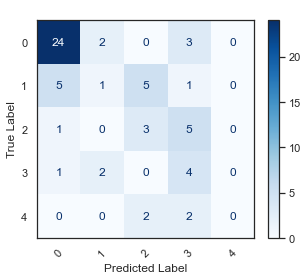

In [157]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
ada_scores = cross_val_score(ada, X_train_prepared, y_train, scoring='f1_macro', cv=5)
print("mean cv macro_f1 score: {}".format(round(ada_scores.mean(),3)))

ada.fit(X_train_prepared, y_train)
y_test_pred = ada.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
plotconfusion(ada, X_test_prepared, y_test)

### SVM

mean cv macro_f1 score: 0.338
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.20      0.17      0.18        12
           2       0.11      0.11      0.11         9
           3       0.27      0.43      0.33         7
           4       0.33      0.25      0.29         4

    accuracy                           0.52        61
   macro avg       0.36      0.36      0.36        61
weighted avg       0.53      0.52      0.53        61



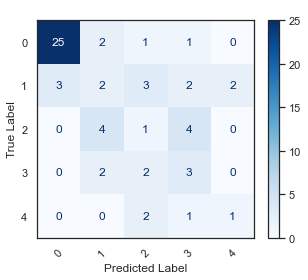

In [158]:
svc = SVC(class_weight='balanced')
svc_scores = cross_val_score(svc, X_train_prepared, y_train, scoring='f1_macro', cv=5)
print("mean cv macro_f1 score: {}".format(round(svc_scores.mean(),3)))

svc.fit(X_train_prepared, y_train)
y_test_pred = svc.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
plotconfusion(svc, X_test_prepared, y_test)

**Observations**

Baseline models are not able to give good performance, to try other models and tuning hyperparameters

## Hyperparameter tuning <a name='5.2'></a>

#### make custom scorer (f1_macro), can also use sklearn.metrics.precision_recall_support

In [159]:
# define custom loss function for cv
# another way to deal with imbalance class, by putting weights into custom loss function in gridsearchcv # eg. by rewarding more for perhaps class 4 TP and penalty more for class 4 TP

from sklearn import metrics as met

def custom_loss_func(y_actual, y_pred):
    
    num_class = len(np.unique(y_actual))
    
    #tune weights
    weights = [1,1,1,1,1]
    
    cm = confusion_matrix(y_actual, y_pred)
    
    tp = {}
    fp = {}
    fn = {}
    
    #true positive
    for hv in range(0,num_class):
        tp["tp{}".format(hv)] = cm[hv,hv]*weights[hv] 
    
    #false positive
    for v in range(0,num_class):
        fp["fp{}".format(v)] = 0
        for h in range(0,num_class):
            if h != v:
                fp["fp{}".format(v)] += cm[h,v]
        fp["fp{}".format(v)] *= weights[v] 
    
    #false negative
    for h in range(0,num_class):
        fn["fn{}".format(h)] = 0
        for v in range(0,num_class):
            if h != v:
                fn["fn{}".format(h)] += cm[h,v]
        fn["fn{}".format(h)] *= weights[h] 
    
    recall = {}
    precision = {}
    f1 = {}
    
    for i in range(0,num_class):
        recall["recall{}".format(i)] = tp["tp{}".format(i)]/(tp["tp{}".format(i)]+fn["fn{}".format(i)])
        precision["precision{}".format(i)] = tp["tp{}".format(i)]/(tp["tp{}".format(i)]+ fp["fp{}".format(i)]+0.000001)
        f1["f1_{}".format(i)] = 2*(precision["precision{}".format(i)]*recall["recall{}".format(i)]/(precision["precision{}".format(i)]+recall["recall{}".format(i)]+0.000001))
    
    
    macro_f1 = sum(f1.values())/len(f1)

    return macro_f1


custom_scorer = met.make_scorer(custom_loss_func, greater_is_better=True)

In [160]:
#creating weight array based on inverse frequency for train set
weights = []
n_samples = len(y_train)
n_classes = len(np.unique(y_train))
counts = y_train.groupby(y_train).count()
for i in y_train:
    if i == 0:
        weights.append(n_samples/(n_classes*counts.loc[0]))
    elif i == 1:
        weights.append(n_samples/(n_classes*counts.loc[1]))
    elif i == 2:
        weights.append(n_samples/(n_classes*counts.loc[2]))
    elif i == 3:
        weights.append(n_samples/(n_classes*counts.loc[3]))
    elif i == 4:
        weights.append(n_samples/(n_classes*counts.loc[4]))
        
y_train_weights = list(zip(np.array(y_train),weights))

In [161]:
#creating different weights based on inverse frequency for train set, and increasing emphasis on Class 4 
class_weight_dict = {0 : n_samples/(n_classes*counts.loc[0]),
                     1 : n_samples/(n_classes*counts.loc[1]),
                     2 : n_samples/(n_classes*counts.loc[2]),
                     3 : n_samples/(n_classes*counts.loc[3]),
                     4 : n_samples/(n_classes*counts.loc[4])}

class_weight_dict2 = {0 : n_samples/(n_classes*counts.loc[0]),
                     1 : n_samples/(n_classes*counts.loc[1]),
                     2 : n_samples/(n_classes*counts.loc[2]),
                     3 : n_samples/(n_classes*counts.loc[3]),
                     4 : n_samples/(n_classes*counts.loc[4])*1.2}

class_weight_dict3 = {0 : n_samples/(n_classes*counts.loc[0]),
                     1 : n_samples/(n_classes*counts.loc[1]),
                     2 : n_samples/(n_classes*counts.loc[2]),
                     3 : n_samples/(n_classes*counts.loc[3]),
                     4 : n_samples/(n_classes*counts.loc[4])*1.5}

class_weight_dict4 = {0 : n_samples/(n_classes*counts.loc[0]),
                     1 : n_samples/(n_classes*counts.loc[1]),
                     2 : n_samples/(n_classes*counts.loc[2]),
                     3 : n_samples/(n_classes*counts.loc[3]),
                     4 : n_samples/(n_classes*counts.loc[4])*1.8}


### Linear model - kernel SVM <a name='5.2.1'></a>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset[num_cols + cat_cols] ,dataset['num'], test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [164]:
param_grid = {'kernel': ['rbf', 'poly'],
              'degree' : [2,3,4,5],
              'gamma': ['scale', 0.01, 0.1, 1],
              'C': [ 0.1, 0.5, 1, 1.5, 2, 2.5]}

#class weight balance for auto scaling of weights based on inverse frequency
svm_gs = GridSearchCV(estimator=SVC(class_weight='balanced'),
                      param_grid=param_grid, scoring='f1_macro', cv=5)

svm_gs.fit(X_train_prepared, y_train)

print(svm_gs.best_params_)
print(svm_gs.best_score_)

params = {}
params['kernel'] = svm_gs.best_params_['kernel']
params['gamma'] = svm_gs.best_params_['gamma'] 
params['degree'] = svm_gs.best_params_['degree'] 
params['C'] = svm_gs.best_params_['C']

final_mdl = SVC(**params,decision_function_shape='ovo',class_weight='balanced')
final_mdl 

{'C': 1.5, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.3463216826648748


SVC(C=1.5, class_weight='balanced', decision_function_shape='ovo', degree=2)

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.10      0.08      0.09        12
           2       0.10      0.11      0.11         9
           3       0.25      0.43      0.32         7
           4       1.00      0.25      0.40         4

    accuracy                           0.51        61
   macro avg       0.47      0.35      0.36        61
weighted avg       0.55      0.51      0.51        61



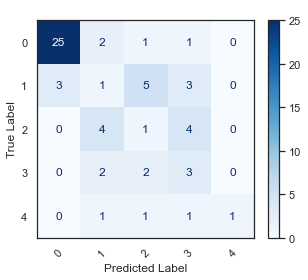

In [165]:
final_mdl.fit(X_train_prepared, y_train)
y_test_pred = final_mdl.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
plotconfusion(final_mdl, X_test_prepared, y_test)

### Decision tree : LGBM - boosting and bagging <a name='5.2.2'></a>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset[num_cols + cat_cols] ,dataset['num'], test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [289]:
params = {
    'metric': 'multi_logloss',
}

param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [70],
    'num_leaves': [20], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt'], 
    'reg_alpha' : [0.3],
    'reg_lambda' : [3],
    'max_depth' : [4],
    'min_child_weight': [0.01],
    'min_child_samples': [25],
    'cat_smooth':[0],
    'colsample_bytree':[0.8],   #feature fraction
    'subsample':[0.8],         #bagging fraction
    'subsample_freq':[4],        #bagging freq
    'min_split_gain' : [0.6],
    'class_weight' : [class_weight_dict,class_weight_dict2,class_weight_dict3,class_weight_dict4]
    }



mdl = lgb.LGBMClassifier(objective = 'multiclass',
          num_class = 5,
          is_unbalance = True
        ) 

lgbm_gs = GridSearchCV(mdl, param_grid=param_grid, verbose=1, scoring='f1_macro', cv=5)

lgbm_gs.fit(X_train_prepared, y_train)

print(lgbm_gs.best_params_)
print(lgbm_gs.best_score_)

params = {}
hyperparams = ['learning_rate', 'n_estimators', 'num_leaves', 'boosting_type', 'reg_alpha','reg_lambda', 'max_depth', 'min_child_weight', 'min_child_samples','cat_smooth', 'colsample_bytree','subsample',  'subsample_freq','min_split_gain', 'class_weight' ]

for param in hyperparams:
    params[param] = lgbm_gs.best_params_[param]

final_mdl = lgb.LGBMClassifier(**params,
          objective = 'multiclass',
          num_class = 5,
          is_unbalance = True
         )

final_mdl.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'boosting_type': 'gbdt', 'cat_smooth': 0, 'class_weight': {0: 0.3585185185185185, 1: 1.1255813953488372, 2: 1.7925925925925925, 3: 1.7285714285714286, 4: 5.377777777777778}, 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_samples': 25, 'min_child_weight': 0.01, 'min_split_gain': 0.6, 'n_estimators': 70, 'num_leaves': 20, 'reg_alpha': 0.3, 'reg_lambda': 3, 'subsample': 0.8, 'subsample_freq': 4}
0.33698567415552605


LGBMClassifier(cat_smooth=0,
               class_weight={0: 0.3585185185185185, 1: 1.1255813953488372,
                             2: 1.7925925925925925, 3: 1.7285714285714286,
                             4: 5.377777777777778},
               colsample_bytree=0.8, is_unbalance=True, learning_rate=0.01,
               max_depth=4, min_child_samples=25, min_child_weight=0.01,
               min_split_gain=0.6, n_estimators=70, num_class=5, num_leaves=20,
               objective='multiclass', reg_alpha=0.3, reg_lambda=3,
               subsample=0.8, subsample_freq=4)

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        29
           1       0.42      0.42      0.42        12
           2       0.33      0.33      0.33         9
           3       0.36      0.57      0.44         7
           4       0.25      0.25      0.25         4

    accuracy                           0.61        61
   macro avg       0.46      0.48      0.47        61
weighted avg       0.65      0.61      0.62        61



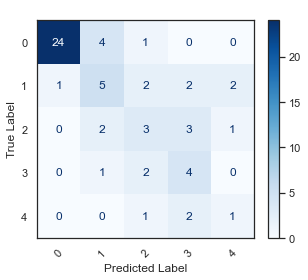

In [292]:
final_mdl.fit(X_train_prepared, y_train)
y_test_pred = final_mdl.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
plotconfusion(final_mdl, X_test_prepared, y_test)

   **Observation**
   
Based on gridsearchcv, the best weights to use is the inverse frequency with 1.2 factor on class 4, however, this is poor in predicting Class 4 heart disease which has the most severe impact. We can try using even higher weights for class 4 to achieve higher `recall` on class 4 and compare the results

In [168]:
del params['class_weight']

              precision    recall  f1-score   support

           0       0.95      0.72      0.82        29
           1       0.25      0.17      0.20        12
           2       0.17      0.11      0.13         9
           3       0.50      0.43      0.46         7
           4       0.16      0.75      0.26         4

    accuracy                           0.49        61
   macro avg       0.41      0.44      0.38        61
weighted avg       0.60      0.49      0.52        61



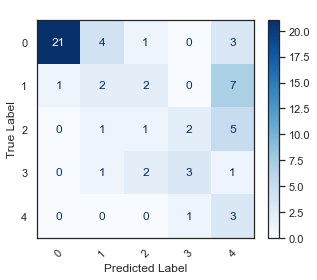

In [169]:
final_mdl = lgb.LGBMClassifier(**params,
          objective = 'multiclass',
          num_class = 5,
          is_unbalance = True,
          class_weight = class_weight_dict4                     
         )

final_mdl.fit(X_train_prepared, y_train)

y_test_pred = final_mdl.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
plotconfusion(final_mdl, X_test_prepared, y_test)

   **Observation**
   
By applying a 1.8 factor to inverse frequency weightings of class 4, we can successfully identify all 3 out of 4 cases of class 4 heart disease, however performance of other classes suffers as there are more less severe class get over diagnosed as class 4.

### Neural Network <a name='5.2.3'></a>

In [344]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model

In [365]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      #keras.metrics.TruePositives(name='tp'),         #these metrics only work for binary, we will use our custom made metric
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),  # area under the roc curve
      #keras.metrics.AUC(name='prc', curve='PR') # area under precision-recall curve
]

def build_model(num_features, metrics=METRICS, output_bias=None):
    # set initial bias to log of the odds
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    inputs = tfl.Input(shape=(num_features,))
    A1 = tfl.Dense(units=16, activation='relu')(inputs)
    A2 = tfl.Dense(units=32, activation='relu')(A1)
    D1 = tfl.Dropout(0.5)(A2)                                #drop out regularization
    outputs = tfl.Dense(units=5, activation='softmax', bias_initializer=output_bias)(D1)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=metrics)

    return model

def plot_loss(history, label, n):
    plt.figure(dpi=100, figsize=(6, 4))
    plt.plot(history.epoch, 
             history.history['loss'],
             color=colors[n], 
             label='Train ' + label)
    plt.plot(history.epoch, 
             history.history['val_loss'],
             color=colors[n], 
             label='Test ' + label,
             linestyle='--')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
def plot_metrics(history):
    plt.figure(dpi=100, figsize=(12, 8))
    metrics = ['accuracy']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, 
                 history.history[metric], 
                 color=colors[1],
                 label='Train')
        plt.plot(history.epoch, 
                 history.history['val_' + metric], 
                 color=colors[1],
                 label='Test',
                 linestyle='--')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout(pad=1.5)

In [366]:
#weight dictionaries <-- to demonstrate gridsearch cv using different weights
class_weight_dict = {0 : n_samples/(n_classes*counts.loc[0]),
                     1 : n_samples/(n_classes*counts.loc[1]),
                     2 : n_samples/(n_classes*counts.loc[2]),
                     3 : n_samples/(n_classes*counts.loc[3]),
                     4 : n_samples/(n_classes*counts.loc[4])}

class_weight_dict2 = {0 : n_samples/(n_classes*counts.loc[0]),
                     1 : n_samples/(n_classes*counts.loc[1]),
                     2 : n_samples/(n_classes*counts.loc[2]),
                     3 : n_samples/(n_classes*counts.loc[3]),
                     4 : n_samples/(n_classes*counts.loc[4])*1.5}

In [367]:
from sklearn.model_selection import KFold
import itertools

#pre processing
X_train1, X_test1, y_train1, y_test1 = train_test_split(dataset[num_cols + cat_cols] ,dataset['num'], test_size=0.2, random_state=42)
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared1 = preprocessor.fit_transform(X_train1)
X_test_prepared1 = preprocessor.transform(X_test1)

param_grid = {'class_weight' : [class_weight_dict,class_weight_dict2],
              'EPOCHS' : [200],
              'BATCH_SIZE' : [100]
             }  #to demonstrate gridsearchcv on KERAS neuralnetwork, no tuning of nn model in this excercise, however it is possible

gridscore = {}

#generate grid from param_grid
keys, values = zip(*param_grid.items())
grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

#loop through grid
for i in range(len(grid)):
    f1_macrolist = []

    #kfold-cv
    kf = KFold(n_splits=2)
    for train_index, test_index in kf.split(X_train_prepared1):

        #split train set
        X_train, X_test = X_train_prepared1[train_index], X_train_prepared1[test_index]
        y_train, y_test = np.array(y_train1)[train_index], np.array(y_train1)[test_index]

        #for NN
        train_features = X_train
        train_labels = np.array(y_train)
        test_features = X_test
        test_labels = np.array(y_test)

        #build model
        EPOCHS = grid[i]['EPOCHS']
        BATCH_SIZE = grid[i]['BATCH_SIZE']

        model = build_model(num_features=X_train_prepared1.shape[-1],
                            output_bias=[0.3585,1.1255,1.792,1.728,5.377]  #initialize bias for using inverse frequency of class
                           )
        #model.summary()

        #fit model
        baseline_history = model.fit(train_features, train_labels,
                                 batch_size=BATCH_SIZE,
                                 epochs=EPOCHS,
                                 validation_data=(test_features, test_labels),
                                 class_weight= grid[i]['class_weight'],  #use inverse frequency weights
                                 verbose = 0
                                )
        #validate on "test" (still within train set)
        y_test_pred = model.predict(X_test)
        idx = np.argmax(y_test_pred, axis=-1)

        #append f1_macro results
        f1_macrolist.append(custom_loss_func(y_test, idx)) # we use the f1_macro created from the custom scorer previously

    f1_macro_mean = np.mean(f1_macrolist)
    gridscore[str(grid[i])] = f1_macro_mean

4/4 [==============================] - 0s 1000us/step


In [368]:
best_score = max(gridscore.values())
best_params = max(gridscore, key=gridscore.get)
print("grid_best_params: {}\ngrid_best_score: {}".format(best_params, round(best_score,3)))

grid_best_params: {'class_weight': {0: 0.3585185185185185, 1: 1.1255813953488372, 2: 1.7925925925925925, 3: 1.7285714285714286, 4: 5.377777777777778}, 'EPOCHS': 200, 'BATCH_SIZE': 100}
grid_best_score: 0.301


In [369]:
#use optimal hyperparameters from gridsearchcv to predict test set

EPOCHS = 200  #we can also find best epoch and best batch size from gridsearchcv
BATCH_SIZE = 100
model = build_model(num_features=X_train_prepared1.shape[-1],
                        output_bias=[0.3585,1.1255,1.792,1.728,5.377]  #initialize bias for using inverse frequency of class
                        )

train_features = X_train_prepared1
train_labels = np.array(y_train1)
test_features = X_test_prepared1
test_labels = np.array(y_test1)

model_history = model.fit(train_features, train_labels,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          validation_data=(test_features, test_labels),
                          class_weight=class_weight_dict,  #determined from gridsearchcv
                          verbose = 0
                         )

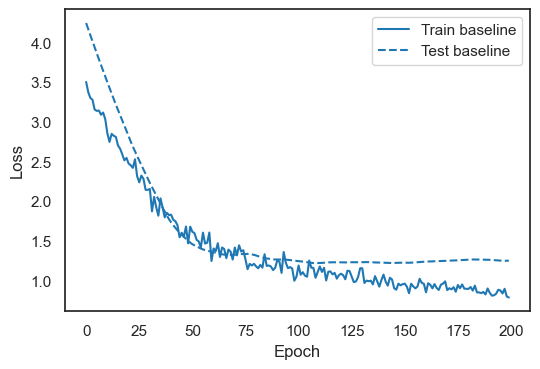

In [370]:
plot_loss(baseline_history, 'baseline', 1)

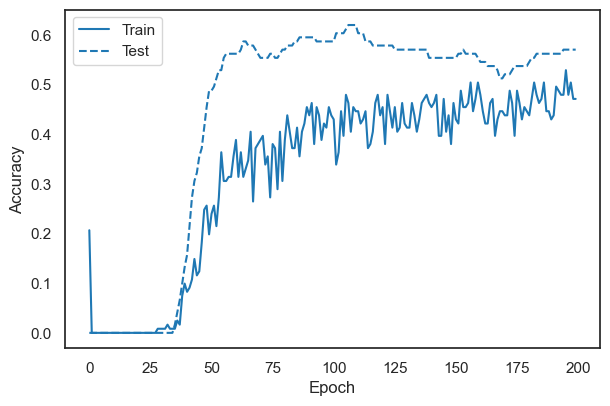

In [371]:
plot_metrics(baseline_history)

2/2 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       0.11      0.08      0.10        12
           2       0.42      0.56      0.48         9
           3       0.22      0.29      0.25         7
           4       0.50      0.25      0.33         4

    accuracy                           0.57        61
   macro avg       0.43      0.41      0.41        61
weighted avg       0.57      0.57      0.57        61



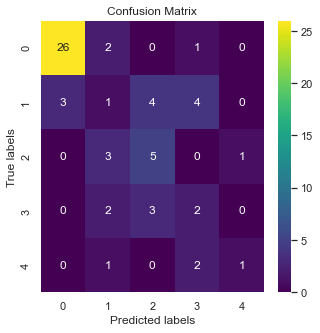

In [373]:
y_test_pred = model.predict(X_test_prepared1)
idx = np.argmax(y_test_pred, axis=-1)

print(classification_report(y_test1, idx))
#print(confusion_matrix(y_test1, idx))
cm = confusion_matrix(y_test1, idx)

fig, ax= plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'viridis');  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

### Comparison bewteen 3 supervised learning models - kernel svm, lgbm and neural network

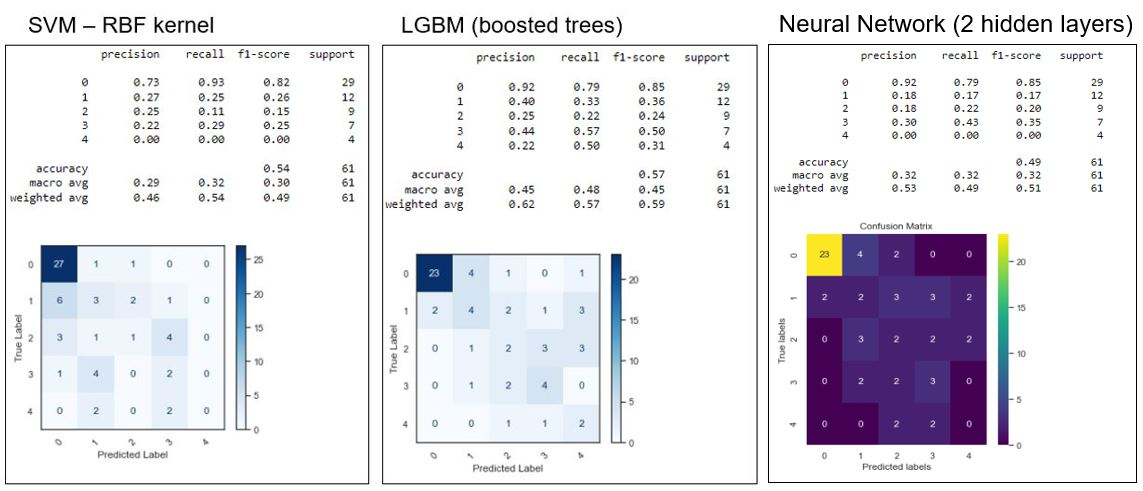

we see that neural network is performing badly, this is because hyperparameters were not vigorously tuned due to computational resources constraint

<a name="6"></a>
# 6 - Modeling - unsupervised learning

In [316]:
# pca - kmeans
# GMM
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

sns.set_style("darkgrid")
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})

### Lets refresh ourselves with the data again

In [190]:
dataset.head()

age     sex    dataset               cp  trestbps  chol    fbs  \
0   63    Male  Cleveland   typical angina       145   233   True   
1   67    Male  Cleveland     asymptomatic       160   286  False   
2   67    Male  Cleveland     asymptomatic       120   229  False   
3   37    Male  Cleveland      non-anginal       130   250  False   
4   41  Female  Cleveland  atypical angina       130   204  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy     150  False      2.3  downsloping  0.0   
1  lv hypertrophy     108   True      1.5         flat  3.0   
2  lv hypertrophy     129   True      2.6         flat  2.0   
3          normal     187  False      3.5  downsloping  0.0   
4  lv hypertrophy     172  False      1.4    upsloping  0.0   

                thal  num age_group  chol_group thalch_group  oldpeak_log  \
0       fixed defect    0  (60, 65]  (200, 250]   (140, 160]     1.193922   
1             normal    2  (65, 70]  (250, 300]   (100, 120]     0.916291   
2  reversable defect    1  (65, 70]  (200, 250]   (120, 140]     1.280934   
3             normal    0  (28, 40]  (200, 250]   (180, 203]     1.504077   
4             normal    0  (40, 45]  (200, 250]   (160, 180]     0.875469   

  oldpeak_group trestbps_group  
0    (2.0, 2.5]     (140, 150]  
1    (1.0, 1.5]     (150, 160]  
2    (2.5, 3.0]     (110, 120]  
3    (3.0, 3.5]     (120, 130]  
4    (1.0, 1.5]     (120, 130]

In [191]:
cat_cols

['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [192]:
num_cols

['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

### Preprocessing

In [193]:
X_train, X_test, y_train, y_test = train_test_split(dataset[num_cols + cat_cols] ,dataset['num'], test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

featurelist = list(preprocessor.get_feature_names_out(X_train.columns))

In [194]:
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns = featurelist)
X_test_prepared_df = pd.DataFrame(X_test_prepared, columns = featurelist)

### PCA <a name="6.1"></a>

Conduct PCA only after scaling

- PCA is useful as we observe multi-colinearity between the features from previous section. After removing colinearity through PCA, feature importance analysis post modelling will be more robust
- Since some information are lost, some accuracy may be sacrificed (performance vs feature explainability trade-off)

In [195]:
pca = PCA(n_components = len(featurelist))
scaled_pca_train = pca.fit_transform(X_train_prepared_df)
scaled_pca_test = pca.transform(X_test_prepared_df)

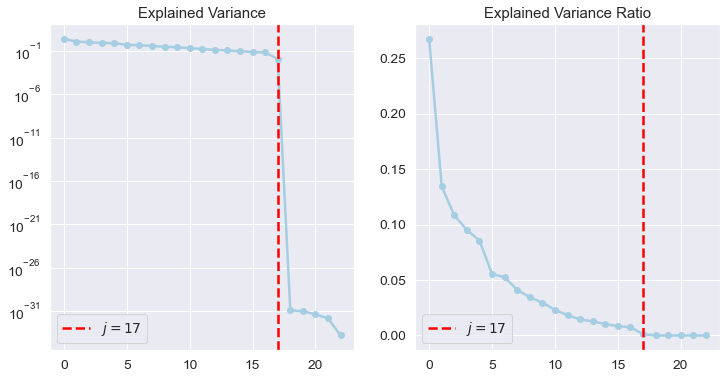

In [197]:
fig, ax= plt.subplots(figsize=(12, 6))

plt.subplot(121)
plt.semilogy(pca.explained_variance_, '-o')
plt.axvline(x=17, c='r', ls='--', label=r'$j=17$')
plt.title('Explained Variance')
plt.legend()

plt.subplot(122)
plt.plot(pca.explained_variance_ratio_, '-o')
plt.axvline(x=17, c='r', ls='--', label=r'$j=17$')
plt.title('Explained Variance Ratio')
plt.legend()

- The explained variance drops drastically after the 17th component
- The top 5 components contribute to majority of the explained variance

#### Checking variable contribution for Top N principal components

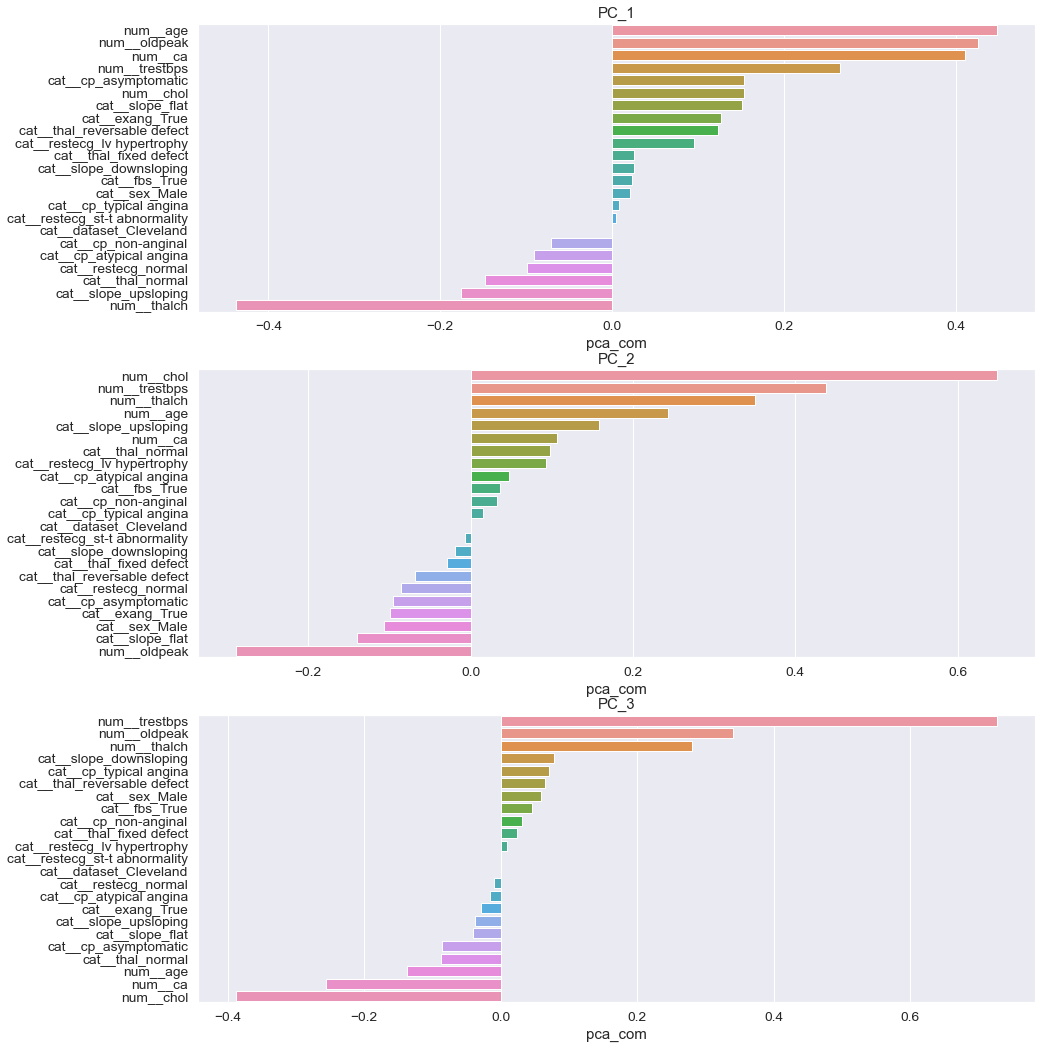

In [198]:
n_check = 3
fig, ax = plt.subplots(n_check, 1, figsize=(15, n_check*6))

for i in range(0, n_check):    
    
    df = pd.DataFrame(pca.components_[i],index = X_train_prepared_df.columns, columns = ['pca_com'])
    df = df.sort_values(by = ['pca_com'],ascending = False)
    
    sns.barplot(x='pca_com', y=df.index, data=df, orient='h', ax=ax[i])
    ax[i].set_title('PC_{}'.format(i+1))

### Kmeans clustering using top 17 PCs from PCA. <a name="6.1.1"></a>

In [199]:
from sklearn.cluster import KMeans

In [200]:
pca = PCA(n_components = 17)
scaled_pca_train = pca.fit_transform(X_train_prepared_df)
scaled_pca_test = pca.transform(X_test_prepared_df)

In [201]:
n_clust = 5
kmeans = KMeans(n_clusters=n_clust, random_state=65)
clusters_train = kmeans.fit_predict(scaled_pca_train)

After we get the clusters from unsupervised learning, we need a way to determine which cluster is pointing to which class. Here, we determine that by counting the max number of points in each class in each cluster scaled by their weights (inverse frequency)

In [202]:
#define a function for weight scaling to determine class from cluster label
def scalebyweights(x):
    if x == 0:
        v = 0.3585185185185185
    elif x == 1:
        v = 1.1255813953488372
    elif x == 2:
        v = 1.7925925925925925
    elif x == 3:
        v = 1.7285714285714286
    elif x == 4:
        v = 5.377777777777778
    return v

In [203]:
#function to get cluster label to class encoding
def getencoding(train_result, n_clust):
    kmean_encode = {}
    for i in range (0,n_clust):
        c_value = train_result[train_result['labels']==i]
        c_value['scaled_counts'] = c_value['y_train_num'].apply(lambda x : scalebyweights(x)) # here we scale counts by inverse frequency 
        groupcount = c_value.groupby(['y_train_num'])['scaled_counts'].sum() # we sum up all the scaled counts for each cluster group by each class
        v = groupcount.loc[groupcount.values == groupcount.max()].index[0] # get the class with the max counts

        kmean_encode[i] = v #cluster_label = class
    return kmean_encode

In [204]:
#function to transform predicted cluster to class
def label_to_class(old_arr,kmean_encode):
    new_arr = []
    for i in old_arr:
        new_arr.append(kmean_encode[i])
    return np.array(new_arr)

In [205]:
# first, we concat the clustering results and original y_train
labels = kmeans.labels_
train_result = pd.DataFrame({'labels':labels.tolist(), 'y_train_num':list(y_train)})

#get cluster label to class dictionary
labeldict = getencoding(train_result, n_clust)

#predict on test set
cluster_test = kmeans.predict(scaled_pca_test)

#transform cluster label to class
y_test_pred = label_to_class(cluster_test,labeldict)

              precision    recall  f1-score   support

           0       0.82      0.79      0.81        29
           1       0.00      0.00      0.00        12
           2       0.20      0.67      0.31         9
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         4

    accuracy                           0.48        61
   macro avg       0.20      0.29      0.22        61
weighted avg       0.42      0.48      0.43        61



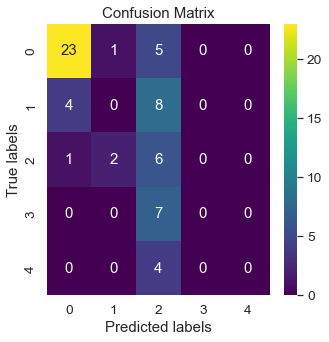

In [206]:
print(classification_report(y_test, y_test_pred))
#print(confusion_matrix(y_test1, idx))
cm = confusion_matrix(y_test, y_test_pred)

fig, ax= plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'viridis');  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

### Now, lets do gridsearchcv on kmeans to find the best number of clusters

In [207]:
import itertools

#pre processing

#one hot and standard scaling ============================================================
X_train1, X_test1, y_train1, y_test1 = train_test_split(dataset[num_cols + cat_cols] ,dataset['num'], test_size=0.2, random_state=42)
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared1 = preprocessor.fit_transform(X_train1)
X_test_prepared1 = preprocessor.transform(X_test1)
#=========================================================================================

#PCA======================================================================================
X_train_prepared_df = pd.DataFrame(X_train_prepared1, columns = featurelist)
X_test_prepared_df = pd.DataFrame(X_test_prepared1, columns = featurelist)

pca = PCA(n_components = 17)
scaled_pca_train = pca.fit_transform(X_train_prepared_df)
scaled_pca_test = pca.transform(X_test_prepared_df)
#=========================================================================================

param_grid = {'n_clust' : [5,6,7,8,9,10]
             }  

gridscore = {}

#generate grid from param_grid
keys, values = zip(*param_grid.items())
grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

#loop through grid
for i in range(len(grid)):
    f1_macrolist = []

    #kfold-cv
    kf = KFold(n_splits=2)
    for train_index, test_index in kf.split(scaled_pca_train):

        #split train set
        X_train, X_test = scaled_pca_train[train_index], scaled_pca_train[test_index]
        y_train, y_test = np.array(y_train1)[train_index], np.array(y_train1)[test_index]

        #kmeans
        n_clust = grid[i]['n_clust']
        kmeans = KMeans(n_clusters=n_clust, random_state=65)
        clusters_train = kmeans.fit_predict(X_train)
        
        #get labeldict from comparing with X_train with y_train
        labels = kmeans.labels_
        train_result = pd.DataFrame({'labels':labels.tolist(), 'y_train_num':list(y_train)})
        labeldict = getencoding(train_result, n_clust)  
        
        #predict x_test
        cluster_test = kmeans.predict(X_test)
        
        #transform cluster label to class
        y_test_pred = label_to_class(cluster_test,labeldict)

        #append f1_macro results
        f1_macrolist.append(custom_loss_func(y_test, y_test_pred)) # we use the f1_macro created from the custom scorer previously

    f1_macro_mean = np.mean(f1_macrolist)
    gridscore[str(grid[i])] = f1_macro_mean

In [208]:
best_score = max(gridscore.values())
best_params = max(gridscore, key=gridscore.get)
print("grid_best_params: {}\ngrid_best_score: {}".format(best_params, round(best_score,3)))

grid_best_params: {'n_clust': 6}
grid_best_score: 0.271


In [209]:
#use hyperparameters from gridsearchcv to fit on train data and test on test data
n_clust = 6     #obtained from gridsearchcv
kmeans = KMeans(n_clusters=n_clust, random_state=65)
clusters_train = kmeans.fit_predict(scaled_pca_train)

#get label dict
labels = kmeans.labels_
train_result = pd.DataFrame({'labels':labels.tolist(), 'y_train_num':list(y_train1)})
labeldict = getencoding(train_result, n_clust) 

#predict x_test
cluster_test = kmeans.predict(scaled_pca_test)  
y_test_pred = label_to_class(cluster_test,labeldict)

              precision    recall  f1-score   support

           0       0.88      0.79      0.84        29
           1       0.25      0.08      0.12        12
           2       0.19      0.33      0.24         9
           3       0.20      0.43      0.27         7
           4       0.00      0.00      0.00         4

    accuracy                           0.49        61
   macro avg       0.30      0.33      0.29        61
weighted avg       0.52      0.49      0.49        61



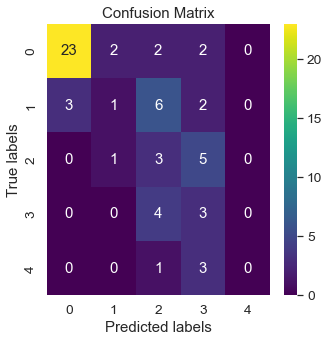

In [210]:
print(classification_report(y_test1, y_test_pred))
#print(confusion_matrix(y_test1, idx))
cm = confusion_matrix(y_test1, y_test_pred)

fig, ax= plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'viridis');  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

### Kmeans clustering without PCA. <a name="6.1.2"></a>

In [211]:
import itertools

#pre processing

#one hot and standard scaling ============================================================
X_train1, X_test1, y_train1, y_test1 = train_test_split(dataset[num_cols + cat_cols] ,dataset['num'], test_size=0.2, random_state=42)
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared1 = preprocessor.fit_transform(X_train1)
X_test_prepared1 = preprocessor.transform(X_test1)
#=========================================================================================


param_grid = {'n_clust' : [5,7,10,12,15]
             }  

gridscore = {}

#generate grid from param_grid
keys, values = zip(*param_grid.items())
grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

#loop through grid
for i in range(len(grid)):
    f1_macrolist = []

    #kfold-cv
    kf = KFold(n_splits=2)
    for train_index, test_index in kf.split(X_train_prepared1):

        #split train set
        X_train, X_test = X_train_prepared1[train_index], X_train_prepared1[test_index]
        y_train, y_test = np.array(y_train1)[train_index], np.array(y_train1)[test_index]

        #kmeans
        n_clust = grid[i]['n_clust']
        kmeans = KMeans(n_clusters=n_clust, random_state=65)
        clusters_train = kmeans.fit_predict(X_train)
        
        #get labeldict from comparing with X_train with y_train
        labels = kmeans.labels_
        train_result = pd.DataFrame({'labels':labels.tolist(), 'y_train_num':list(y_train)})
        labeldict = getencoding(train_result, n_clust)  
        
        #predict x_test
        cluster_test = kmeans.predict(X_test)
        
        #transform cluster label to class
        y_test_pred = label_to_class(cluster_test,labeldict)

        #append f1_macro results
        f1_macrolist.append(custom_loss_func(y_test, y_test_pred)) # we use the f1_macro created from the custom scorer previously

    f1_macro_mean = np.mean(f1_macrolist)
    gridscore[str(grid[i])] = f1_macro_mean

In [212]:
best_score = max(gridscore.values())
best_params = max(gridscore, key=gridscore.get)
print("grid_best_params: {}\ngrid_best_score: {}".format(best_params, round(best_score,3)))

grid_best_params: {'n_clust': 10}
grid_best_score: 0.266


In [213]:
#use hyperparameters from gridsearchcv to fit on train data and test on test data
n_clust = 10     #obtained from gridsearchcv
kmeans = KMeans(n_clusters=n_clust, random_state=65)
clusters_train = kmeans.fit_predict(X_train_prepared1)

#get label dict
labels = kmeans.labels_
train_result = pd.DataFrame({'labels':labels.tolist(), 'y_train_num':list(y_train1)})
labeldict = getencoding(train_result, n_clust) 

#predict x_test
cluster_test = kmeans.predict(X_test_prepared1)  
y_test_pred = label_to_class(cluster_test,labeldict)

              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.40      0.17      0.24        12
           2       0.24      0.44      0.31         9
           3       0.00      0.00      0.00         7
           4       0.33      0.75      0.46         4

    accuracy                           0.56        61
   macro avg       0.36      0.44      0.37        61
weighted avg       0.53      0.56      0.52        61



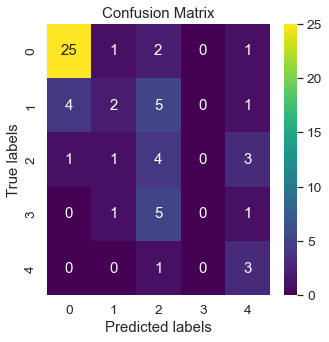

In [214]:
print(classification_report(y_test1, y_test_pred))
#print(confusion_matrix(y_test1, idx))
cm = confusion_matrix(y_test1, y_test_pred)

fig, ax= plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'viridis');  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

**Observations**

Accuracy decreases when using top 17 features for PCA. This may be because some information are lost during PCA decompositon.

### GMM using top 17 PCs from PCA. <a name="6.1.3"></a>

In [317]:
from sklearn.mixture import GaussianMixture

### Preprocessing and PCA

In [318]:
X_train, X_test, y_train, y_test = train_test_split(dataset[num_cols + cat_cols] ,dataset['num'], test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

featurelist = list(preprocessor.get_feature_names_out(X_train.columns))

In [319]:
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns = featurelist)
X_test_prepared_df = pd.DataFrame(X_test_prepared, columns = featurelist)

In [320]:
pca = PCA(n_components = 17)
scaled_pca_train = pca.fit_transform(X_train_prepared_df)
scaled_pca_test = pca.transform(X_test_prepared_df)

In [321]:
scaled_pca_train_df = pd.DataFrame(scaled_pca_train, columns = pca.get_feature_names_out(X_train_prepared_df.columns))
scaled_pca_test_df = pd.DataFrame(scaled_pca_test, columns = pca.get_feature_names_out(X_test_prepared_df.columns))

In [322]:
scaled_pca_train_df['num'] = list(y_train)
scaled_pca_test_df['num'] = list(y_test)

Split the dataset into no heart disease and heart disease

In [323]:
train_0=scaled_pca_train_df.loc[scaled_pca_train_df['num'] == 0].copy()
train_1=scaled_pca_train_df.loc[scaled_pca_train_df['num'] != 0].copy()

test_0=scaled_pca_test_df.loc[scaled_pca_test_df['num'] == 0].copy()
test_1=scaled_pca_test_df.loc[scaled_pca_test_df['num'] != 0].copy()

In [324]:
pcs = train_0.columns.tolist()
pcs.remove('num')

switch to a binary classification problem for simplification due to very little data from each class for GMM to work reasonably well  

In [326]:
test_1['num'] = 1
train_1['num'] = 1

In [327]:
x_train, x_test, y_train, y_test = train_0[pcs], test_0[pcs], train_0['num'], test_0['num']
x_train1, x_test1, y_train1, y_test1 = train_1[pcs], test_1[pcs], train_1['num'], test_1['num']

In [329]:
gmm = GaussianMixture(n_components=1) 

In [330]:
gmm.fit(x_train)

GaussianMixture()

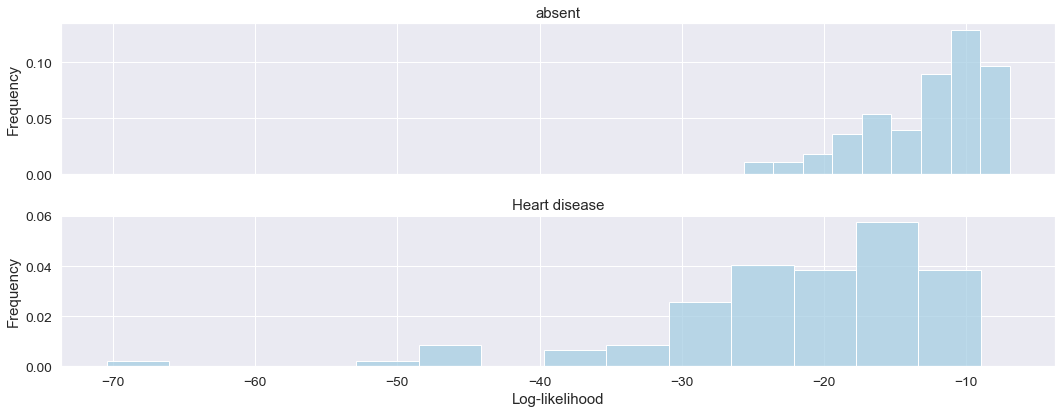

In [331]:
fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
sns.histplot(gmm.score_samples(x_train), stat='density', ax=ax[0])
sns.histplot(gmm.score_samples(x_train1), stat='density', ax=ax[1])

ax[0].set_title('absent')
ax[1].set_title('Heart disease')

for a in ax:
    a.set_xlabel('Log-likelihood')
    a.set_ylabel('Frequency')
    
fig.tight_layout()

now, we decide a suitable threshold for log-likelihood to determine the class

In [332]:
from sklearn.metrics import precision_recall_fscore_support
def evaluate_threshold(x, y, thresholds):
    log_likelihoods = gmm.score_samples(x)
    precisions = []
    recalls = []
    f1s = []
    for t in thresholds:
        y_pred = 1 * (log_likelihoods < t)
        p, r, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary')
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    return precisions, recalls, f1s

In [333]:
x_train_combined = np.concatenate([x_train, x_train1])
y_train_combined = np.concatenate([y_train, y_train1])

In [334]:
thresholds = np.linspace(-100, -5, 10)

In [335]:
p_train, r_train, f1_train = evaluate_threshold(x_train_combined, y_train_combined, thresholds)

Text(0.5, 0, 'Thresholds for log-likelihood')

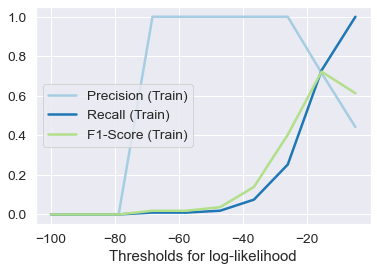

In [336]:
plt.plot(thresholds, p_train, label='Precision (Train)')
plt.plot(thresholds, r_train, label='Recall (Train)')
plt.plot(thresholds, f1_train, label='F1-Score (Train)')
plt.legend()
plt.xlabel('Thresholds for log-likelihood')

we choose the threshold when f1 is highest

In [337]:
chosen_threshold = thresholds[np.argmax(f1_train)]

In [338]:
x_test_combined = np.concatenate([x_test, x_test1])
y_test_combined = np.concatenate([y_test, y_test1])
y_test_pred = gmm.score_samples(x_test_combined) < chosen_threshold

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        29
           1       0.81      0.81      0.81        32

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



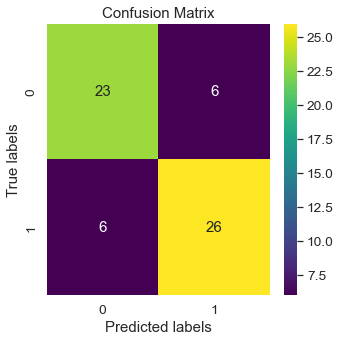

In [339]:
print(classification_report(y_test_combined, y_test_pred))
cm = confusion_matrix(y_test_combined, y_test_pred)

fig, ax= plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'viridis');  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

### Now, lets do gridsearchcv on GMM to find the best number of components

In [340]:
import itertools

#pre processing

#one hot and standard scaling ============================================================
X_train1, X_test1, y_train1, y_test1 = train_test_split(dataset[num_cols + cat_cols] ,dataset['num'], test_size=0.2, random_state=42)
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared1 = preprocessor.fit_transform(X_train1)
X_test_prepared1 = preprocessor.transform(X_test1)
#=========================================================================================

#PCA======================================================================================
X_train_prepared_df = pd.DataFrame(X_train_prepared1, columns = featurelist)
X_test_prepared_df = pd.DataFrame(X_test_prepared1, columns = featurelist)

pca = PCA(n_components = 17)
scaled_pca_train = pca.fit_transform(X_train_prepared_df)
scaled_pca_test = pca.transform(X_test_prepared_df)
#=========================================================================================

param_grid = {'n_comp' : [1,2,3,4,5,6,7,8]
             }  

gridscore = {}

#generate grid from param_grid
keys, values = zip(*param_grid.items())
grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

#loop through grid
for i in range(len(grid)):
    f1_macrolist = []

    #kfold-cv
    kf = KFold(n_splits=2)
    for train_index, test_index in kf.split(scaled_pca_train):

        #split train set
        X_train, X_test = scaled_pca_train[train_index], scaled_pca_train[test_index]
        y_train, y_test = np.array(y_train1)[train_index], np.array(y_train1)[test_index]
        
        #scaled_pca_train -> X_train and X_test
        scaled_pca_train_df = pd.DataFrame(X_train, columns = pca.get_feature_names_out(X_train_prepared_df.columns))
        scaled_pca_test_df = pd.DataFrame(X_test, columns = pca.get_feature_names_out(X_test_prepared_df.columns))
        
        #Split the dataset into no heart disease and heart disease
        scaled_pca_train_df['num'] = list(y_train)
        scaled_pca_test_df['num'] = list(y_test)
        
        train_0=scaled_pca_train_df.loc[scaled_pca_train_df['num'] == 0].copy()
        train_1=scaled_pca_train_df.loc[scaled_pca_train_df['num'] != 0].copy()

        test_0=scaled_pca_test_df.loc[scaled_pca_test_df['num'] == 0].copy()
        test_1=scaled_pca_test_df.loc[scaled_pca_test_df['num'] != 0].copy()
        
        pcs = train_0.columns.tolist()
        pcs.remove('num')
        
        #switch to a binary classification problem for simplification due to very little data from each class for GMM to work reasonably well 

        
        test_1['num'] = 1
        train_1['num'] = 1
        
        x_train_0, x_test_0, y_train_0, y_test_0 = train_0[pcs], test_0[pcs], train_0['num'], test_0['num']
        x_train_1, x_test_1, y_train_1, y_test_1 = train_1[pcs], test_1[pcs], train_1['num'], test_1['num']
        

        gmm = GaussianMixture(n_components=grid[i]['n_comp']) 
        gmm.fit(x_train_0)
        
        x_train_combined = np.concatenate([x_train_0, x_train_1])
        y_train_combined = np.concatenate([y_train_0, y_train_1])
        
        thresholds = np.linspace(-100, -5, 10)
        p_train, r_train, f1_train = evaluate_threshold(x_train_combined, y_train_combined, thresholds)
        chosen_threshold = thresholds[np.argmax(f1_train)]
        
        x_test_combined = np.concatenate([x_test_0, x_test_1])
        y_test_combined = np.concatenate([y_test_0, y_test_1])
        y_test_pred = gmm.score_samples(x_test_combined) < chosen_threshold

        #append f1_macro results
        f1_macrolist.append(custom_loss_func(y_test_combined, y_test_pred)) # we use the f1_macro created from the custom scorer previously

    f1_macro_mean = np.mean(f1_macrolist)
    gridscore[str(grid[i])] = f1_macro_mean

In [341]:
best_score = max(gridscore.values())
best_params = max(gridscore, key=gridscore.get)
print("grid_best_params: {}\ngrid_best_score: {}".format(best_params, round(best_score,3)))

grid_best_params: {'n_comp': 2}
grid_best_score: 0.688


#### lets use n_components = 1 to predict

In [342]:
scaled_pca_train_df = pd.DataFrame(scaled_pca_train, columns = pca.get_feature_names_out(X_train_prepared_df.columns))
scaled_pca_test_df = pd.DataFrame(scaled_pca_test, columns = pca.get_feature_names_out(X_test_prepared_df.columns))

scaled_pca_train_df['num'] = list(y_train1)
scaled_pca_test_df['num'] = list(y_test1)

train_0=scaled_pca_train_df.loc[scaled_pca_train_df['num'] == 0].copy()
train_1=scaled_pca_train_df.loc[scaled_pca_train_df['num'] != 0].copy()

test_0=scaled_pca_test_df.loc[scaled_pca_test_df['num'] == 0].copy()
test_1=scaled_pca_test_df.loc[scaled_pca_test_df['num'] != 0].copy()

pcs = test_0.columns.tolist()
pcs.remove('num')

x_train_0, x_test_0, y_train_0, y_test_0 = train_0[pcs], test_0[pcs], train_0['num'], test_0['num']
x_train_1, x_test_1, y_train_1, y_test_1 = train_1[pcs], test_1[pcs], train_1['num'], test_1['num']

test_1['num'] = 1
train_1['num'] = 1

gmm = GaussianMixture(n_components=2) #from gridsearchcv
gmm.fit(x_train_0)

x_train_combined = np.concatenate([x_train_0, x_train_1])
y_train_combined = np.concatenate([y_train_0, y_train_1])

thresholds = np.linspace(-100, -5, 10)
p_train, r_train, f1_train = evaluate_threshold(x_train_combined, y_train_combined, thresholds)
chosen_threshold = thresholds[np.argmax(f1_train)]

x_test_combined = np.concatenate([x_test_0, x_test_1])
y_test_combined = np.concatenate([y_test_0, y_test_1])
y_test_pred = gmm.score_samples(x_test_combined) < chosen_threshold

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        29
           1       0.83      0.78      0.81        32

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



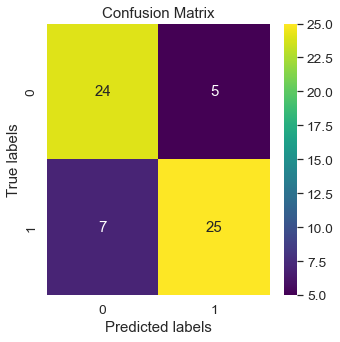

In [343]:
print(classification_report(y_test_combined, y_test_pred))
cm = confusion_matrix(y_test_combined, y_test_pred)

fig, ax= plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'viridis');  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

**Observations**

Not much improvement after tuning the GMM model. Might be because there are many dimensions and relatively little data

<a name="7"></a>
# 7 - Feature Importance Analysis

### Interpretable model - LGBM -> inbuilt feature importance

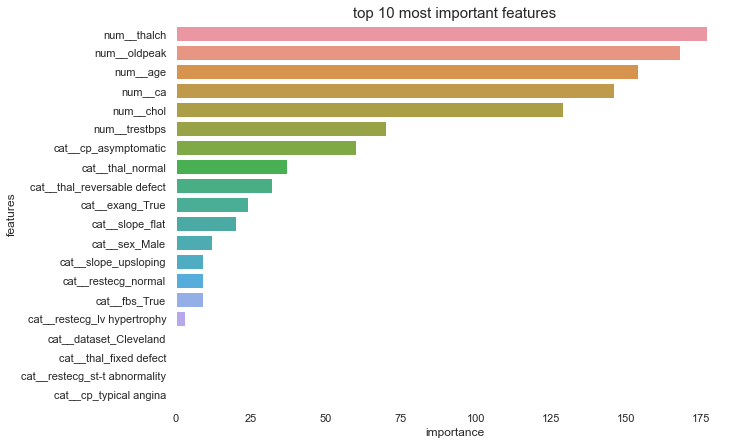

In [295]:
#run LGBM model before running this code
plt.figure(figsize=(10, 7))
feature_importance = pd.DataFrame({'features': preprocessor.get_feature_names_out(X_train.columns), 
                                   'importance': final_mdl.feature_importances_}).sort_values(by='importance', ascending=False)
sns.barplot(data=feature_importance[:20], y='features', x='importance')
sns.despine(left=True, bottom=True)
plt.title('top 10 most important features', fontsize=15);

### Agnostic model - Neural network -> using shap 

In [374]:
import shap
shap.initjs()

In [375]:
#run neural network model before running this code
Xtrain = pd.DataFrame(X_train_prepared1, columns= featurelist)
Xtest = pd.DataFrame(X_test_prepared1, columns= featurelist)

In [376]:
#kernel explainer on train set
nn_explainer = shap.KernelExplainer(model.predict,Xtrain)

8/8 [==============================] - 0s 715us/step


Using 242 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [377]:
#Calculate shap values from test set
shap_values = nn_explainer.shap_values(X = Xtest.iloc[:,:], nsamples = 100)   #takes n samples of any 2 features from all possible combinations

  0%|          | 0/61 [00:00<?, ?it/s]

757/757 [==============================] - 0s 513us/step


### global explainability

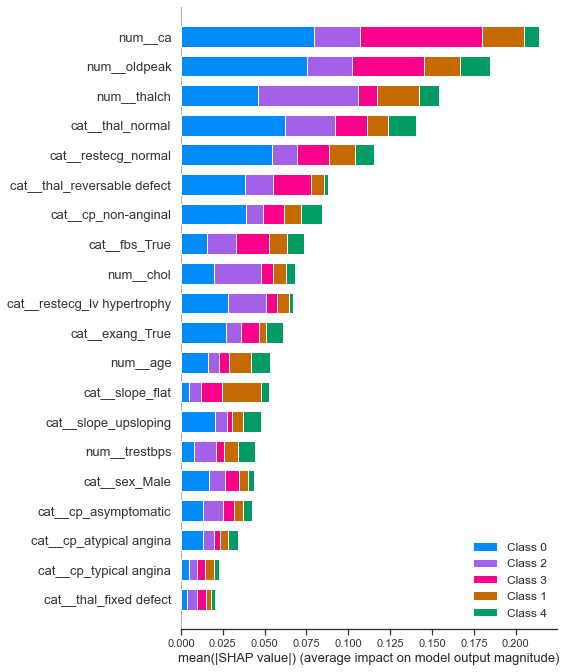

In [378]:
shap.summary_plot(shap_values = shap_values,
                      features = Xtest.iloc[:,:])

class : 0


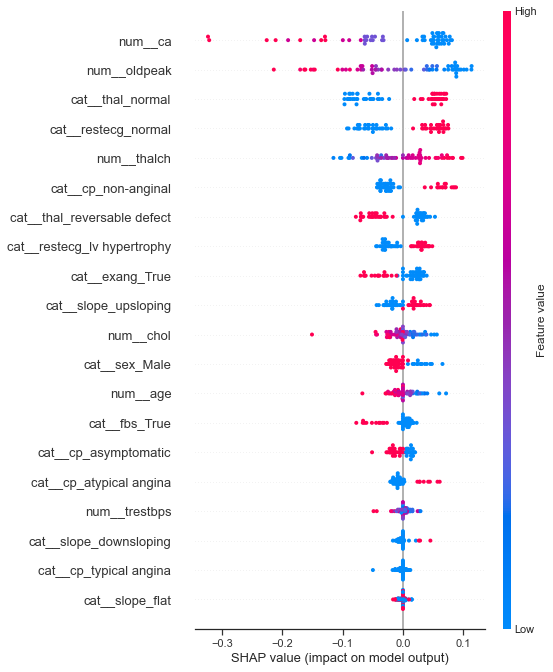

class : 1


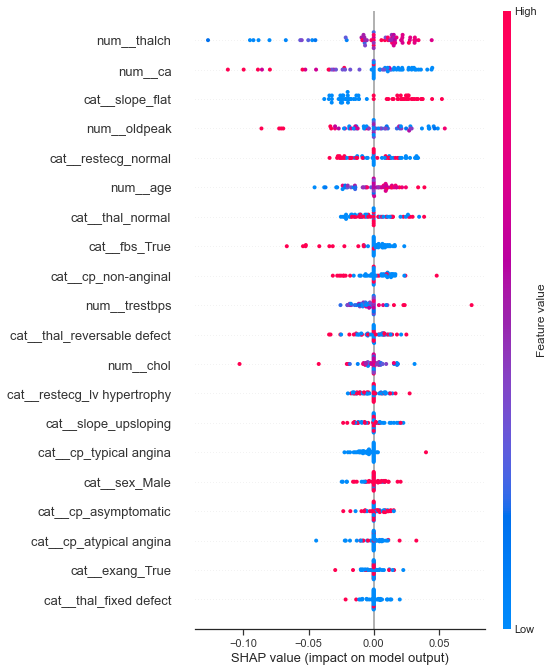

class : 2


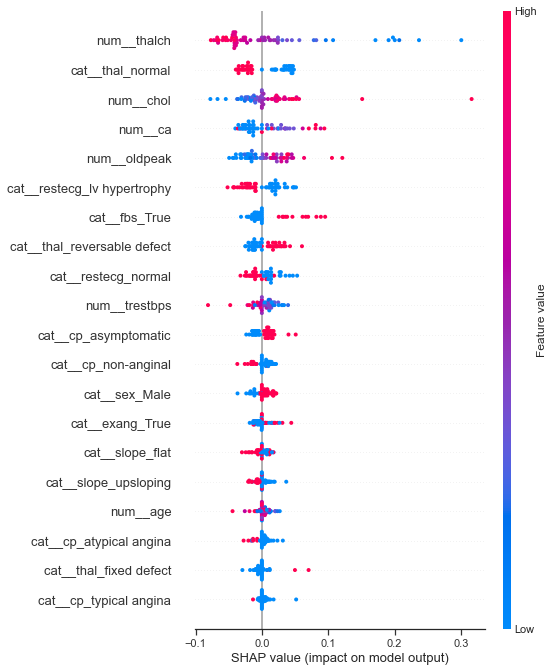

class : 3


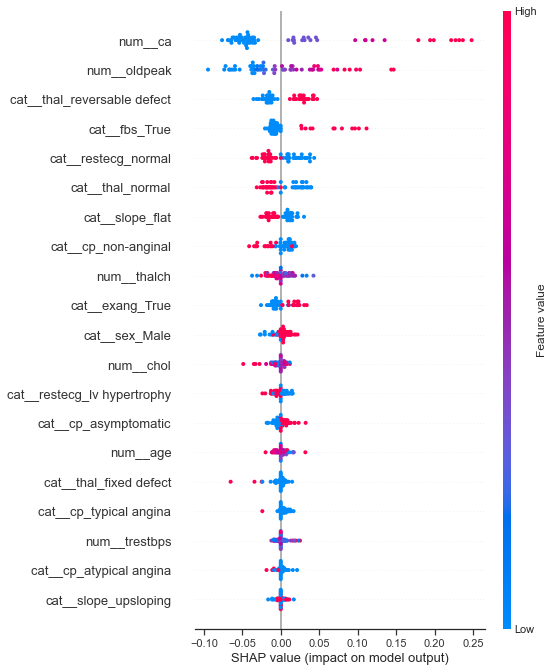

class : 4


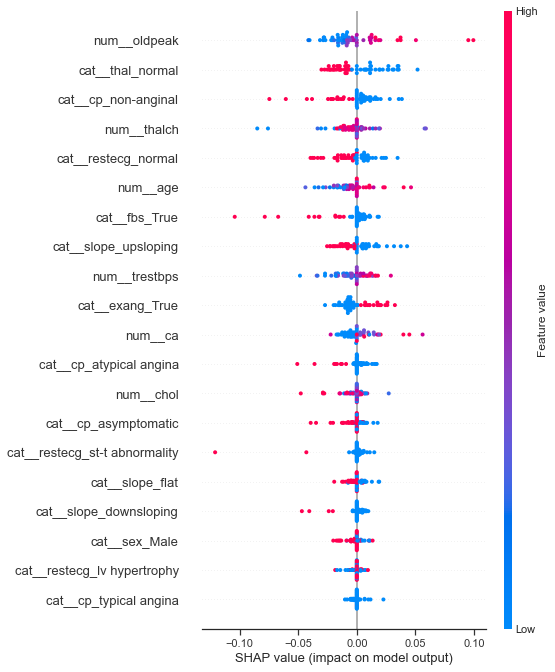

In [380]:
list_of_labels = [0,1,2,3,4]
for i in list_of_labels:
    print("class : {}".format(i))
    shap.summary_plot(shap_values = shap_values[i],
                      features = Xtest.iloc[:,:]
                      )

### local explainability - for first row of test data

In [381]:
shap_values = nn_explainer.shap_values(Xtest.iloc[0,:])

15821/15821 [==============================] - 8s 527us/step


In [384]:
import ipywidgets as widgets

# Create the list of all labels for the drop down list
list_of_labels = [0,1,2,3,4]

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels,
                              value=0,
                              description='Select Label:'
                              )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4)), value=0)

In [386]:
#probability of class 0 is true = 0.32; #probability of class 2 is true = 0.09; etc...
#red features positively influence (bring it to 1), blue features negatively influence (bring it to 0)
shap.force_plot(nn_explainer.expected_value[current_label.value], shap_values[current_label.value], Xtest.iloc[0,:])